In [ ]:
# Processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, time, re, random, torch
! pip install accelerate -U
! pip install transformers[torch] -U
! pip install -U sentence-transformers
!pip install datasets
!pip install bertopic

from datasets import Dataset
from collections import Counter
from statistics import mean
from transformers import BertTokenizer, pipeline,  AutoConfig, TrainingArguments, Trainer, BertModel, BertForSequenceClassification
from sentence_transformers import SentenceTransformer, util
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.representation import KeyBERTInspired, PartOfSpeech, MaximalMarginalRelevance

from nltk.tokenize import word_tokenize
from scipy.spatial.distance import euclidean, cosine, cdist
from scipy.cluster import hierarchy as sch

from sklearn.metrics import (precision_recall_curve,
                             precision_recall_fscore_support,
                             accuracy_score, precision_score,
                             recall_score, confusion_matrix,
                             classification_report,
                             silhouette_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             balanced_accuracy_score)

from sklearn.neighbors import NearestNeighbors
from itertools import product
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.pipeline import Pipeline

import os
os.chdir('/content')
import time
from google.colab import drive
from huggingface_hub import HfFolder, notebook_login
import random

# Import the module
import DBCV

  Using cached bertopic-0.16.2-py2.py3-none-any.whl (158 kB)
  Using cached hdbscan-0.8.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Using cached umap_learn-0.5.6-py3-none-any.whl (85 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.


In [ ]:
drive.mount('/content/drive')

In [ ]:
random.seed(12)

In [ ]:
df = pd.read_csv("Dataset_versions.csv", sep = ",")
df.head()

,Unnamed: 0,Handle,Tweet,threshold_0.4,threshold_0.45,threshold_0.5,threshold_0.55,threshold_0.6,threshold_0.65,threshold_0.7,threshold_0.75,threshold_0.8,threshold_0.85,threshold_0.9,Party
0,0,AGBecerra,['#Breaking: Court just granted our motion to ...,['Abusive payday lenders make money by preying...,['Abusive payday lenders make money by preying...,['The Trump Administration’s assault on clean ...,['We will closely monitor any changes that tr...,"[""I'm pleased that has signed the Fight Onlin...","['Right now, and #California can agree on one...","['Right now, and #California can agree on one...",['TUNE IN at 11AM: I will be announcing a new ...,"["". a medieval wall along our border with #Mex...",['When we said that a medieval wall along the ...,"['Here in #California, we respect the Constitu...",Democrat
1,1,AlanGrayson,"[' 📻TUNE IN📻\n\nMy hubby, and I will join o...",[' To Beat Trump In 2020\nWe Need To Flip Flo...,[' To Beat Trump In 2020\nWe Need To Flip Flo...,[' To Beat Trump In 2020\nWe Need To Flip Flo...,['Trump’s “fiscal policy” bears a striking res...,['You make it possible to represent true progr...,[' ⁉️BUT HER EMAILS⁉️\n\nInstead of investiga...,['#Trump is now holding events in an attempt t...,"["" Hey Florida! 72 hours left! Join Me, Alan ...","["" Hey Florida! 72 hours left! Join Me, Alan ...","["" Hey Florida! 72 hours left! Join Me, Alan ...","["" Hey Florida! 72 hours left! Join Me, Alan ...",Democrat
2,2,AnthonyBrownMD4,"["" I've had the privilege of serving w some of...",[' We are here with in Upper Marlboro on Ele...,[' We are here with in Upper Marlboro on Ele...,[' We are here with in Upper Marlboro on Ele...,"["" Happy Election Day Maryland! A beautiful ...","["" Happy Election Day Maryland! A beautiful ...",[' Congrats to the progressive veterans who w...,[' Veterans are speaking out against the Sena...,['. midnight Monday health proposal is a #RxFo...,['. midnight Monday health proposal is a #RxFo...,"[' info', ' midnight Monday health proposal is...","[' info', ' midnight Monday health proposal is...",Democrat
3,3,AustinScottGA08,"['This week, we have the opportunity to bring ...","["" In case you missed it, we've kicked off th...","["" In case you missed it, we've kicked off th...","["" In case you missed it, we've kicked off th...","["" In case you missed it, we've kicked off th...","['This #NationalDayOfPrayer, please join me in...","['This #NationalDayOfPrayer, please join me in...","['This #NationalDayOfPrayer, please join me in...","["" In case you missed it, we've kicked off th...","["" In case you missed it, we've kicked off th...","["" In case you missed it, we've kicked off th...","["" In case you missed it, we've kicked off th...",Republican
4,4,BennieGThompson,[' H.R. 4895 by passed the House yesterday (...,"[' CBC Chairman signs our 1,300-page #JobsAn...","[' CBC Chairman signs our 1,300-page #JobsAn...","[' CBC Chairman signs our 1,300-page #JobsAn...","[' CBC Chairman signs our 1,300-page #JobsAn...","[' Today at 11:30 AM ET, the CBC will introdu...","[' Today at 11:30 AM ET, the CBC will introdu...","[' Today at 11:30 AM ET, the CBC will introdu...","[' Thank you!', 'Happy Birthday to my friend ...","[' Thank you!', ' Thank you!', ' 🔜 H.R. 4...","[' Thank you!', ' Thank you!', ' 🔜 H.R. 4...","[' Thank you!', ' Thank you!']",Democrat


In [ ]:
df2 = pd.read_csv("Dataset_random_selection.csv", sep = ",")
tweets_dict = dict(zip(df2['Handle'], df2['Random_tweets']))
df['Random_selection'] = df['Handle'].map(tweets_dict)
assert len(df['Random_selection']) == len(df2['Random_tweets'])

In [ ]:
# Renaming the data to abide by transformer conventions
select_data = df[['Handle', 'threshold_0.7', 'Party']]
select_data.rename(columns={f"threshold_0.7": "text", "Party": "label"}, inplace = True)

random_data = df[['Party', 'Random_selection']] # as opposed to select_data
random_data.rename(columns={f"Random_selection": "text", "Party": "label"}, inplace = True)

# Ready for bertopic consumption
docs = select_data['text'].tolist()
docs_rand = random_data['text'].tolist() # as opposed to docs

# Uniform palette
palette = sns.cubehelix_palette(rot=.2)
# id2label mapping
labels = np.unique(df['Party'])
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in id2label.items()}

## A small EDA section calculating the number of tokens in original vs filtered vs randomly sampled data.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

orig_data = df[['Tweet', 'Party']]
orig_data.rename(columns={f"Tweet": "text", "Party": "label"}, inplace = True)
orig_data['Number of Tokens'] = np.empty((len(max_data), 0)).tolist()

for index, row in orig_data.iterrows():
    extracted_paragraphs = row['text']
    extracted_paragraphs = "".join(extracted_paragraphs)
    tokens = []
    tokens.extend(extracted_paragraphs.split())
    num_toks = len(tokens)
    orig_data['Number of Tokens'] = num_toks

# Calculate the mean number of tokens
mean_tokens = orig_data['Number of Tokens'].mean()
print(f"Original data, average num of tokens: {mean_tokens:.2f}")

select_data['Number of Tokens'] = np.empty((len(select_data), 0)).tolist()

for index, row in select_data.iterrows():
    extracted_paragraphs = row['text']
    extracted_paragraphs = "".join(extracted_paragraphs)
    tokens = []
    tokens.extend(extracted_paragraphs.split())
    num_toks = len(tokens)
    select_data['Number of Tokens'] = num_toks

# Calculate the mean number of tokens
mean_tokens = select_data['Number of Tokens'].mean()
print(f"Filtered data, Mean number of tokens: {mean_tokens:.2f}")

random_data['Number of Tokens'] = np.empty((len(df_rand), 0)).tolist()

for index, row in random_data.iterrows():
    extracted_paragraphs = row['text']
    extracted_paragraphs = "".join(extracted_paragraphs)
    tokens = []
    tokens.extend(extracted_paragraphs.split())
    num_toks = len(tokens)
    random_data['Number of Tokens'] = num_toks

# Calculate the mean number of tokens
mean_tokens = random_data['Number of Tokens'].mean()
print(f"Random data, Mean number of tokens: {mean_tokens:.2f}")

## Clustering on pure embeddings
- Case 1: SBERT
- Case 2: SBERT + UMAP

In [ ]:
# Evaluation function for grid search
def clustering_scorer(estimator, X):
    # Apply UMAP transformation
    umap_embedding = estimator['umap'].fit_transform(X)
    # Apply clustering
    cluster_labels = estimator['cluster'].fit_predict(umap_embedding)
    # Calculate silhouette score
    return silhouette_score(umap_embedding, cluster_labels)

# Function to perform grid search for each clustering model
def perform_grid_search(embeddings, cluster_model, param_grid):
    # Create a pipeline with UMAP and the clustering model
    pipeline = Pipeline([
        ('umap', UMAP(min_dist=0.0, metric='cosine')),
        ('cluster', cluster_model)
    ])

    # Grid search on 5-fold cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, scoring=clustering_scorer, cv=5, n_jobs=-1)

    # Fit the grid search
    grid_search.fit(embeddings)

    # Return the best parameters and the best score
    return grid_search.best_params_, grid_search.best_score_

In [ ]:
random_state = 12

# K-means, Spectral and Agglomerative Clustering Models
cluster_model_baseline = KMeans(n_clusters = 2, random_state = random_state)
cluster_model_spectral = SpectralClustering(n_clusters = 2, random_state = random_state, affinity='nearest_neighbors')
cluster_model_agglom = AgglomerativeClustering(n_clusters = 2)
cluster_models = [cluster_model_baseline, cluster_model_spectral, cluster_model_agglom]

In [ ]:
embedderSBERT = SentenceTransformer('all-MiniLM-L6-v2')
# HYPS to tune
param_grid = {
    'umap__n_neighbors': [5, 10, 15, 20, 25]
}

# Filtered data
embeddings = embedderSBERT.encode(docs, convert_to_tensor=True) # On select_data('text').to_list()
embeddings = embeddings.cpu().numpy()

# Random_data
embeddings_rand = embedderSBERT.encode(docs_rand, convert_to_tensor=True) # On select_data('text').to_list()
embeddings_rand = embeddings_rand.cpu().numpy()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

##### Select data

In [ ]:
start_time = time.time()
# Grid search for each clustering model
print("GRID SEARCH ON SELECTED DATA")
results = {}
for model in cluster_models:
    model_name = type(model).__name__
    # Optimizes w.r.t to silhouette scores
    best_params, best_score = perform_grid_search(embeddings, model, param_grid)
    results[model_name] = {'best_params': best_params, 'best_score': best_score}

# Print the results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best Params: {result['best_params']}")
    print(f"Best Score: {result['best_score']}\n")

end_time = time.time()
execution_time = end_time - start_time
print("Execution time: ", execution_time)

GRID SEARCH ON SELECTED DATA


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Model: KMeans
Best Params: {'umap__n_neighbors': 5}
Best Score: 0.45780985355377196

Model: SpectralClustering
Best Params: {'umap__n_neighbors': 5}
Best Score: 0.4539328694343567

Model: AgglomerativeClustering
Best Params: {'umap__n_neighbors': 5}
Best Score: 0.39360891580581664

Execution time:  146.81058311462402


##### Random data

In [ ]:
start_time = time.time()
# Grid search for each clustering model
print("GRID SEARCH ON RANDOM DATA")
results = {}
for model in cluster_models:
    model_name = type(model).__name__
    # Optimizes w.r.t to silhouette scores
    best_params, best_score = perform_grid_search(embeddings_rand, model, param_grid)
    results[model_name] = {'best_params': best_params, 'best_score': best_score}

# Print the results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best Params: {result['best_params']}")
    print(f"Best Score: {result['best_score']}\n")

end_time = time.time()
execution_time = end_time - start_time
print("Execution time: ", execution_time)

GRID SEARCH ON RANDOM DATA
Model: KMeans
Best Params: {'umap__n_neighbors': 10}
Best Score: 0.4673698127269745

Model: SpectralClustering
Best Params: {'umap__n_neighbors': 5}
Best Score: 0.4632705390453339

Model: AgglomerativeClustering
Best Params: {'umap__n_neighbors': 10}
Best Score: 0.4434185862541199

Execution time:  109.69964480400085


In [ ]:
label_map = {'Democrat': 0, 'Republican': 1}
select_data['label'] = select_data['label'].map(label_map)
random_data['label'] = random_data['label'].map(label_map)

##### Select data

In [ ]:
n_neighbours_list = [5,5,5]

start_time = time.time()

for (i, cluster_model), n_neighbours in zip(enumerate(cluster_models), n_neighbours_list):

    umap_model = UMAP(n_neighbors=n_neighbours, n_components=2, min_dist=0.0, metric='cosine', random_state = 12)
    # SBERT embeddings converted to UMAP
    umap_embeddings = umap_model.fit_transform(embeddings)

    user_clusters = cluster_model.fit_predict(umap_embeddings)

    select_data[f'umap_x{i+1}'] = umap_embeddings[:, 0]
    select_data[f'umap_y{i+1}'] = umap_embeddings[:, 1]
    select_data[f'umap_cluster_label{i+1}'] = user_clusters

end_time = time.time()
execution_time = end_time - start_time
print("Execution time: ", execution_time)

Execution time:  5.719756603240967


In [ ]:
assert (embeddings.shape) == (416, 384)

##### Random data

In [ ]:
n_neighbours_list = [5,5,5]

start_time = time.time()

for (i, cluster_model), n_neighbours in zip(enumerate(cluster_models), n_neighbours_list):

    umap_model = UMAP(n_neighbors=n_neighbours, n_components=2, min_dist=0.0, metric='cosine', random_state = 12)
    # SBERT embeddings converted to UMAP
    umap_embeddings_rand = umap_model.fit_transform(embeddings_rand)

    user_clusters_rand = cluster_model.fit_predict(umap_embeddings_rand)

    random_data[f'umap_x{i+1}'] = umap_embeddings_rand[:, 0]
    random_data[f'umap_y{i+1}'] = umap_embeddings_rand[:, 1]
    random_data[f'umap_cluster_label{i+1}'] = user_clusters_rand

end_time = time.time()
execution_time = end_time - start_time
print("Execution time: ", execution_time)

Execution time:  4.58723258972168


In [ ]:
assert (embeddings_rand.shape) == (416, 384)

##### Select_data

In [ ]:
start_time = time.time()

for i, cluster_model in enumerate(cluster_models):

    sbert_embeddings = embeddings
    user_clusters = cluster_model.fit_predict(embeddings)

    # Initialize columns with empty lists
    select_data[f'sbert_x{i+1}'] = [None] * len(select_data)
    select_data[f'sbert_y{i+1}'] = [None] * len(select_data)

    # Separate the embeddings based on the label
    for n, label in enumerate(select_data['label']):
        if label == 0:
            select_data.at[n, f'sbert_x{i+1}'] = embeddings[i]
        elif label == 1:
            select_data.at[n, f'sbert_y{i+1}'] = embeddings[i]

    # Convert the columns to proper numpy arrays or lists
    select_data[f'sbert_x{i+1}'] = select_data[f'sbert_x{i+1}'].apply(lambda x: np.array(x) if x is not None else np.array([]))
    select_data[f'sbert_y{i+1}'] = select_data[f'sbert_y{i+1}'].apply(lambda x: np.array(x) if x is not None else np.array([]))
    select_data[f'sbert_cluster_label{i+1}'] = user_clusters

end_time = time.time()
execution_time = end_time - start_time
print("Execution time: ", execution_time)

Execution time:  1.2278251647949219


In [ ]:
model_names = ["K-means", "Spectral", "Agglomerative"]
cms = {}
print('Clustering based on SBERT embeddings with UMAP reduction: \nClassification report ')
for i, model_name in enumerate(model_names):

    # Evaluation
    cm = confusion_matrix(select_data['label'], select_data[f'umap_cluster_label{i+1}'])
    cms[model_name] = cm
    print("--------------------------")
    print(f"\n{model_name}:")
    print(classification_report(select_data['label'], select_data[f'umap_cluster_label{i+1}']))

Clustering based on SBERT embeddings with UMAP reduction: 
Classification report 
--------------------------

K-means:
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       200
           1       0.63      0.68      0.65       216

    accuracy                           0.63       416
   macro avg       0.63      0.63      0.63       416
weighted avg       0.63      0.63      0.63       416

--------------------------

Spectral:
              precision    recall  f1-score   support

           0       0.35      0.44      0.39       200
           1       0.33      0.26      0.29       216

    accuracy                           0.35       416
   macro avg       0.34      0.35      0.34       416
weighted avg       0.34      0.35      0.34       416

--------------------------

Agglomerative:
              precision    recall  f1-score   support

           0       0.38      0.49      0.43       200
           1       0.34      0.24    

In [ ]:
cms2 = {}
print('Clustering based on SBERT embeddings: Classification report ')
for i, model_name in enumerate(model_names):

    # Evaluation
    cm = confusion_matrix(select_data['label'], select_data[f'sbert_cluster_label{i+1}'])
    cms2[model_name] = cm
    print("--------------------------")
    print(f"\n{model_name}:")
    print(classification_report(select_data['label'], select_data[f'sbert_cluster_label{i+1}']))

Clustering based on SBERT embeddings: Classification report 
--------------------------

K-means:
              precision    recall  f1-score   support

           0       0.52      0.51      0.52       200
           1       0.55      0.56      0.56       216

    accuracy                           0.54       416
   macro avg       0.54      0.54      0.54       416
weighted avg       0.54      0.54      0.54       416

--------------------------

Spectral:
              precision    recall  f1-score   support

           0       0.40      0.54      0.46       200
           1       0.36      0.24      0.29       216

    accuracy                           0.38       416
   macro avg       0.38      0.39      0.37       416
weighted avg       0.38      0.38      0.37       416

--------------------------

Agglomerative:
              precision    recall  f1-score   support

           0       0.49      0.65      0.56       200
           1       0.53      0.37      0.43       216

   

In [ ]:
extra_palette = sns.color_palette(palette='bwr')

# Conflicting UMAP labels
select_data['umap_conflict1'] = (select_data['umap_cluster_label1'] != select_data['label'])
select_data['umap_conflict2'] = (select_data['umap_cluster_label2'] != select_data['label'])
select_data['umap_conflict3'] = (select_data['umap_cluster_label3'] != select_data['label'])

# Conflicting SBERT labels
select_data['sbert_conflict1'] = (select_data['sbert_cluster_label1'] != select_data['label'])
select_data['sbert_conflict2'] = (select_data['sbert_cluster_label2'] != select_data['label'])
select_data['sbert_conflict3'] = (select_data['sbert_cluster_label3'] != select_data['label'])

In [ ]:
len(select_data['sbert_x1'][1]) # SBERT generates embeddings of dimension 384

384

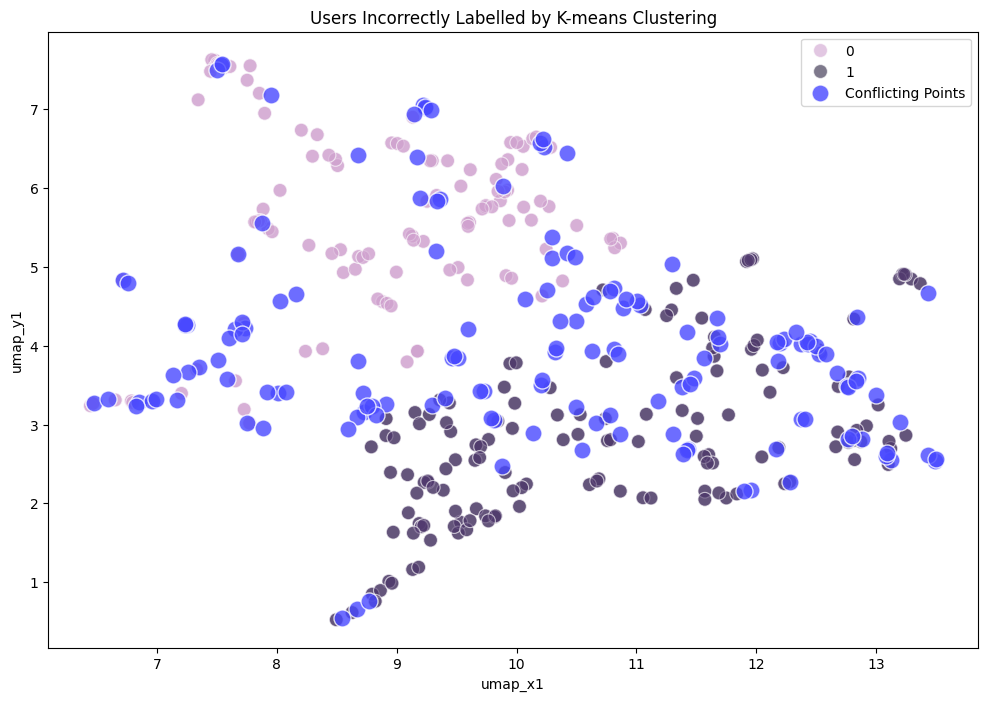

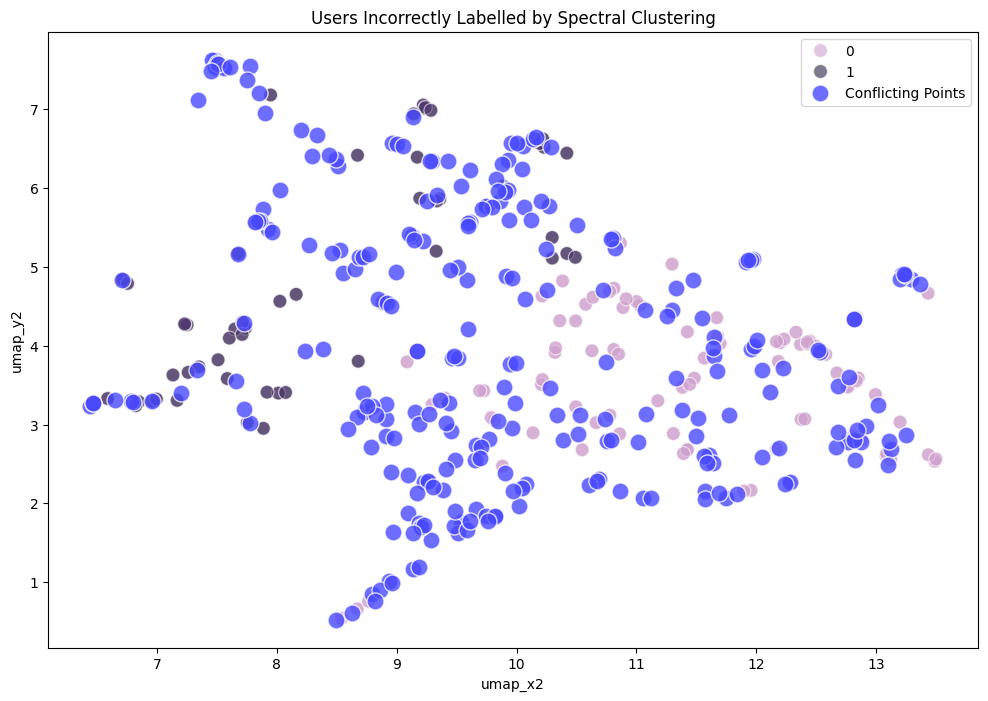

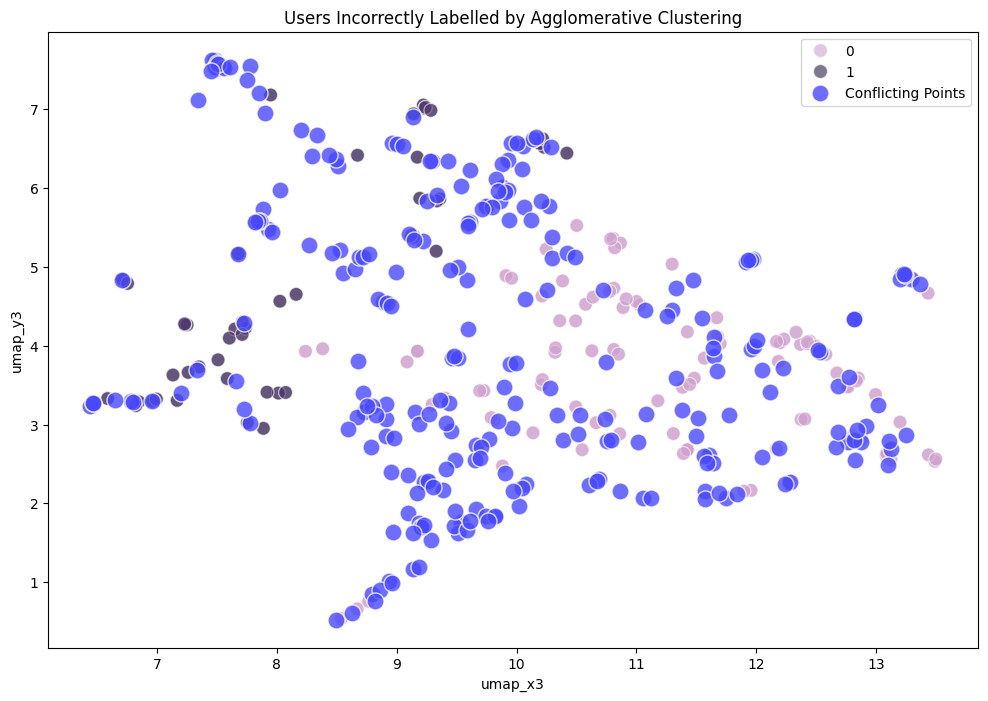

In [ ]:
for i, model_name in enumerate(model_names):

        plt.figure(figsize=(12, 8))

        # Troubleshooting
        x_column = f'umap_x{i+1}'
        y_column = f'umap_y{i+1}'
        cluster_column = f'umap_cluster_label{i+1}'
        conflict_column = f'umap_conflict{i+1}'
        filtered_data = select_data[~select_data[conflict_column]].copy()

        # User clusters without conflicting points
        sns.scatterplot(
            x = x_column,
            y = y_column,
            hue=cluster_column,
            data=filtered_data,
            palette=[palette[1], palette[5]],
            marker='o',
            s=100,
            alpha=0.6
        )

        # Ground truth labels without the conflicting points
        sns.scatterplot(
            x=f'umap_x{i+1}',
            y=f'umap_y{i+1}',
            hue='label',
            data=filtered_data,
            palette=[palette[1], palette[4]],
            marker='o',
            s=100,
            alpha=0.6,
            legend=False  # Disable the legend for ground truth to avoid conflict
        )

        # Highlight conflicting points
        sns.scatterplot(
            x=f'umap_x{i+1}',
            y=f'umap_y{i+1}',
            data=select_data[select_data[f'umap_conflict{i+1}']],
            color=extra_palette[0],
            marker='o',
            s=150,
            alpha=0.8,
            label='Conflicting Points'
        )

        plt.title(f'Users Incorrectly Labelled by {model_name} Clustering')
        plt.legend(loc='upper right', title='')

        plt.show()


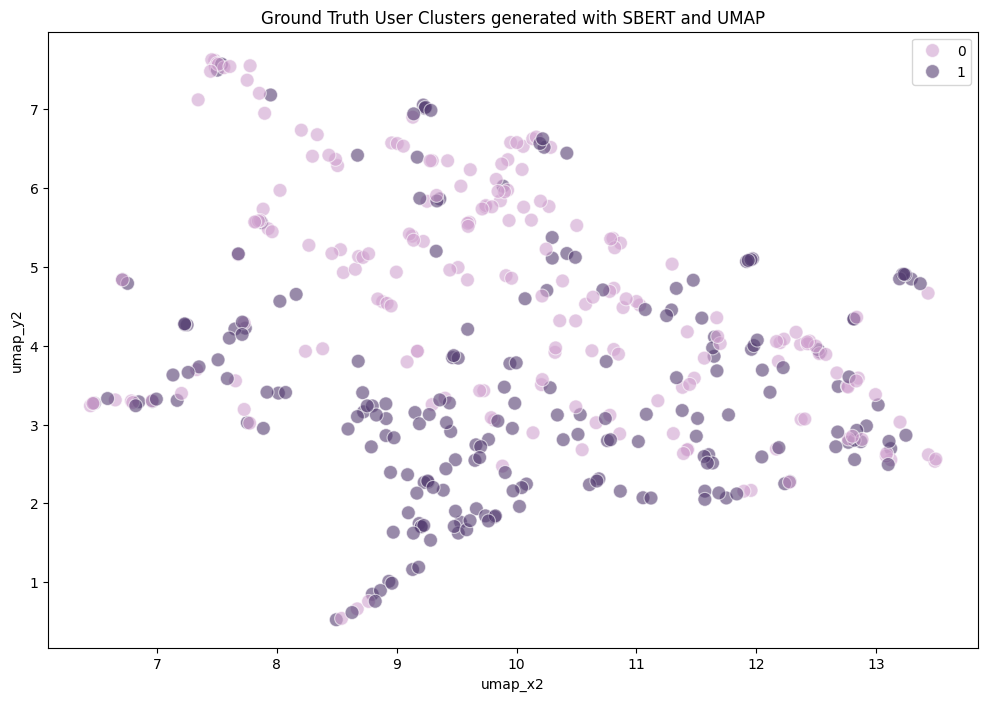

In [ ]:
plt.figure(figsize=(12, 8))

# Ground truth labels without the conflicting points
sns.scatterplot(
    x=f'umap_x2',
    y=f'umap_y2',
    hue='label',
    #data=select_data[~select_data[f'umap_conflict2']],
    data=select_data,
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6,
    legend=True  # Disable the legend for ground truth to avoid conflict
    )

plt.title(f'Ground Truth User Clusters generated with SBERT and UMAP')
plt.legend(loc='upper right', title='')
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score
# Weighted accuracy (not provided by sklearn's classification report?)
y_true = select_data['label']

print("Balanced accuracy results, SBERT + UMAP: ")
for i, model_name in enumerate(cluster_models):

    y_pred = select_data[f'umap_cluster_label{i+1}']
    b_acc = balanced_accuracy_score(y_true.values, y_pred.values)
    print(f'{model_name}: {b_acc}')

print("\nBalanced accuracy results, SBERT: ")
for i, model_name in enumerate(cluster_models):

    y_pred = select_data[f'sbert_cluster_label{i+1}']
    b_acc = balanced_accuracy_score(y_true.values, y_pred.values)
    print(f'{model_name}: {b_acc}')

Balanced accuracy results, SBERT + UMAP: 
KMeans(n_clusters=2, random_state=12): 0.627962962962963
SpectralClustering(affinity='nearest_neighbors', n_clusters=2, random_state=12): 0.3496296296296296
AgglomerativeClustering(): 0.3655555555555555

Balanced accuracy results, SBERT: 
KMeans(n_clusters=2, random_state=12): 0.5374074074074073
SpectralClustering(affinity='nearest_neighbors', n_clusters=2, random_state=12): 0.39037037037037037
AgglomerativeClustering(): 0.5078703703703704


In [ ]:
# DBCV Analysis of Generated Clusters
for i, model_name in enumerate(model_names):
    X = select_data[[f'umap_x{i+1}', f'umap_y{i+1}']].values
    y = select_data[f'umap_cluster_label{i+1}'].values
    score = DBCV.DBCV(X, y)
    print(f"{model_name}: {score}")

# DBCV Analysis of Ground-truth Clusters
X = select_data[[f'umap_x1', f'umap_y1']].values
y = select_data[f'label'].values

score = DBCV.DBCV(X, y)
print(f"Ground Truth Clusters, DBCV: {score}")

K-means: -0.66790432770486
Spectral: -0.7530062019676023
Agglomerative: -0.5757489660296475


In [ ]:
# Silhouette Score Analysis of Generated Clusters
print("Silhouette Scores for data selected with Contextual Similarity filtering.")
print("Generated clusters")
for i, model_name in enumerate(model_names):
    labels = select_data[f'umap_cluster_label{i+1}'].values
    embds = select_data[[f'umap_x1', f'umap_y1']].values
    sil_score = silhouette_score(embds, labels)
    print(f"{model_name}: {score}")

# Silhouette Score Analysis of Ground-truth Clusters
embds = select_data[[f'umap_x1', f'umap_y1']].values
labels = select_data[f'label'].values
sil_score = silhouette_score(embds, labels)
print(f"Ground Truth Clusters: {score}")

Silhouette Scores for clusters generated from similarity filtering of data.
K-means: -0.8954302787347603
Spectral: -0.8954302787347603
Agglomerative: -0.8954302787347603
Ground Truth Clusters: -0.8954302787347603


Random_data results

In [ ]:
start_time = time.time()

for i, cluster_model in enumerate(cluster_models):

    sbert_embeddings_rand = embeddings_rand
    user_clusters_rand = cluster_model.fit_predict(embeddings_rand)

    # Initialize columns
    random_data[f'sbert_x{i+1}'] = [None] * len(random_data)
    random_data[f'sbert_y{i+1}'] = [None] * len(random_data)

    # Separate the embeddings based on the label
    for n, label in enumerate(random_data['label']):
        if label == 0:
            random_data.at[n, f'sbert_x{i+1}'] = embeddings_rand[i]
        elif label == 1:
            random_data.at[n, f'sbert_y{i+1}'] = embeddings_rand[i]

    random_data[f'sbert_x{i+1}'] = random_data[f'sbert_x{i+1}'].apply(lambda x: np.array(x) if x is not None else np.array([]))
    random_data[f'sbert_y{i+1}'] = random_data[f'sbert_y{i+1}'].apply(lambda x: np.array(x) if x is not None else np.array([]))
    random_data[f'sbert_cluster_label{i+1}'] = user_clusters_rand

end_time = time.time()
execution_time = end_time - start_time
print("Execution time: ", execution_time)

Execution time:  1.1842315196990967


In [ ]:
model_names = ["K-means", "Spectral", "Agglomerative"]
cms = {}
print('Clustering based on SBERT embeddings with UMAP reduction: \nClassification report ')
for i, model_name in enumerate(model_names):

    # Evaluation
    cm = confusion_matrix(random_data['label'], random_data[f'umap_cluster_label{i+1}'])
    cms[model_name] = cm
    print("--------------------------")
    print(f"\n{model_name}:")
    print(classification_report(random_data['label'], random_data[f'umap_cluster_label{i+1}']))

Clustering based on SBERT embeddings with UMAP reduction: 
Classification report 
--------------------------

K-means:
              precision    recall  f1-score   support

           0       0.40      0.33      0.36       200
           1       0.46      0.53      0.49       216

    accuracy                           0.44       416
   macro avg       0.43      0.43      0.43       416
weighted avg       0.43      0.44      0.43       416

--------------------------

Spectral:
              precision    recall  f1-score   support

           0       0.39      0.32      0.35       200
           1       0.46      0.54      0.50       216

    accuracy                           0.43       416
   macro avg       0.43      0.43      0.42       416
weighted avg       0.43      0.43      0.43       416

--------------------------

Agglomerative:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       200
           1       0.64      0.70    

In [ ]:
cms2 = {}
print('Clustering based on SBERT embeddings: Classification report ')
for i, model_name in enumerate(model_names):

    # Evaluation
    cm = confusion_matrix(random_data['label'], random_data[f'sbert_cluster_label{i+1}'])
    cms2[model_name] = cm
    print("--------------------------")
    print(f"\n{model_name}:")
    print(classification_report(random_data['label'], random_data[f'sbert_cluster_label{i+1}']))

Clustering based on SBERT embeddings: Classification report 
--------------------------

K-means:
              precision    recall  f1-score   support

           0       0.35      0.34      0.34       200
           1       0.41      0.44      0.42       216

    accuracy                           0.39       416
   macro avg       0.38      0.39      0.38       416
weighted avg       0.39      0.39      0.39       416

--------------------------

Spectral:
              precision    recall  f1-score   support

           0       0.33      0.28      0.31       200
           1       0.41      0.46      0.44       216

    accuracy                           0.38       416
   macro avg       0.37      0.37      0.37       416
weighted avg       0.37      0.38      0.37       416

--------------------------

Agglomerative:
              precision    recall  f1-score   support

           0       0.54      0.74      0.62       200
           1       0.63      0.42      0.50       216

   

In [ ]:
# Conflicting UMAP labels
random_data['umap_conflict1'] = (random_data['umap_cluster_label1'] != random_data['label'])
random_data['umap_conflict2'] = (random_data['umap_cluster_label2'] != random_data['label'])
random_data['umap_conflict3'] = (random_data['umap_cluster_label3'] != random_data['label'])


# Conflicting SBERT labels
random_data['sbert_conflict1'] = (random_data['sbert_cluster_label1'] != random_data['label'])
random_data['sbert_conflict2'] = (random_data['sbert_cluster_label2'] != random_data['label'])
random_data['sbert_conflict3'] = (random_data['sbert_cluster_label3'] != random_data['label'])

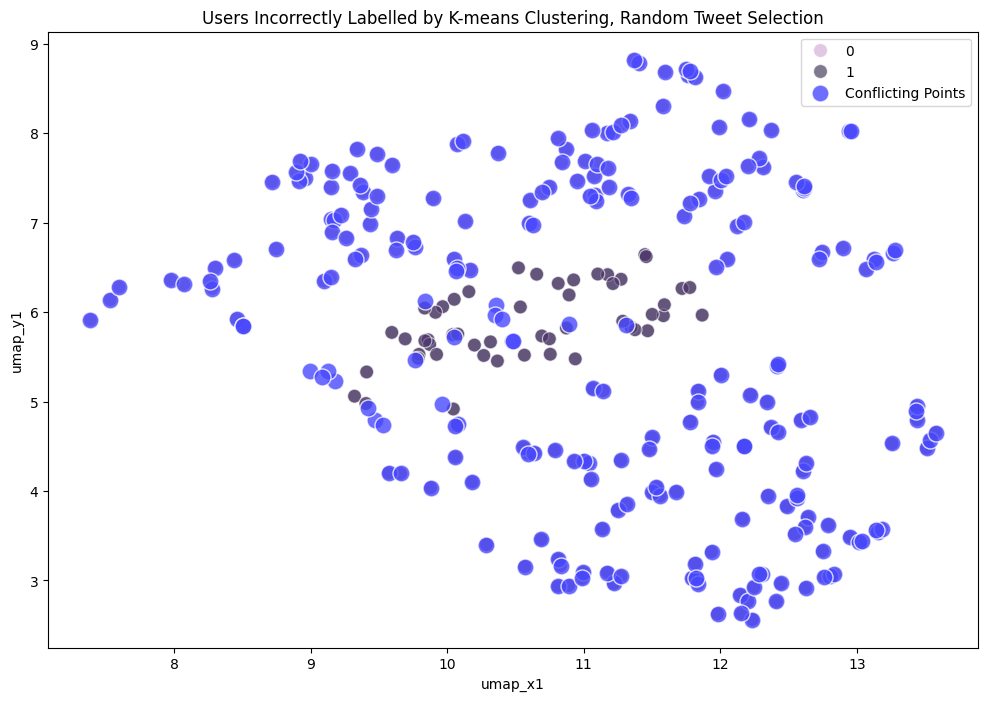

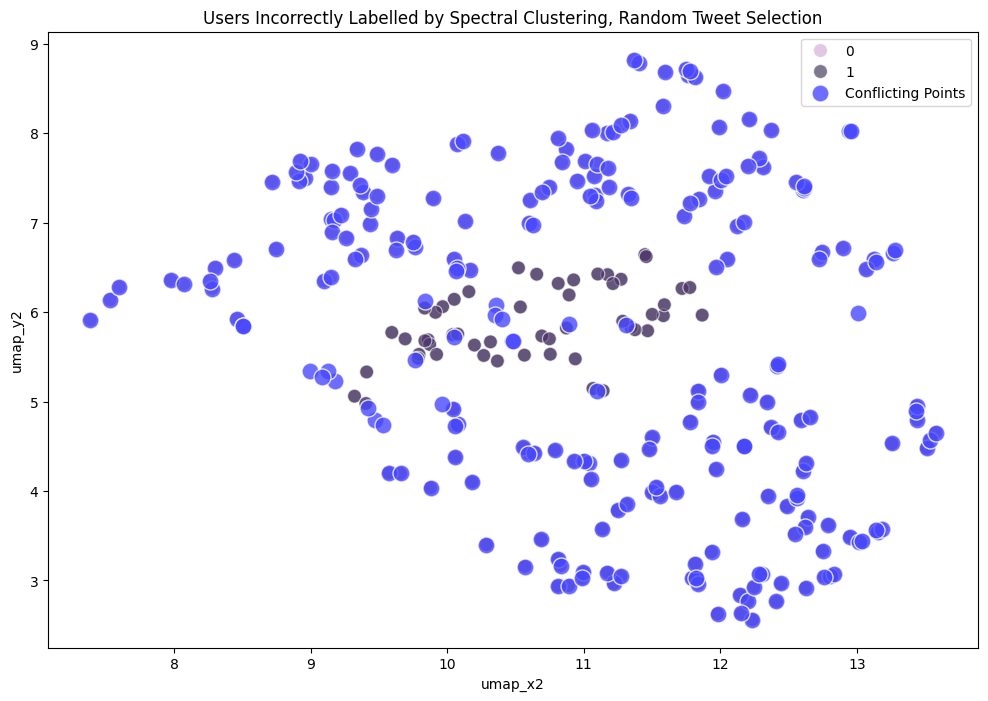

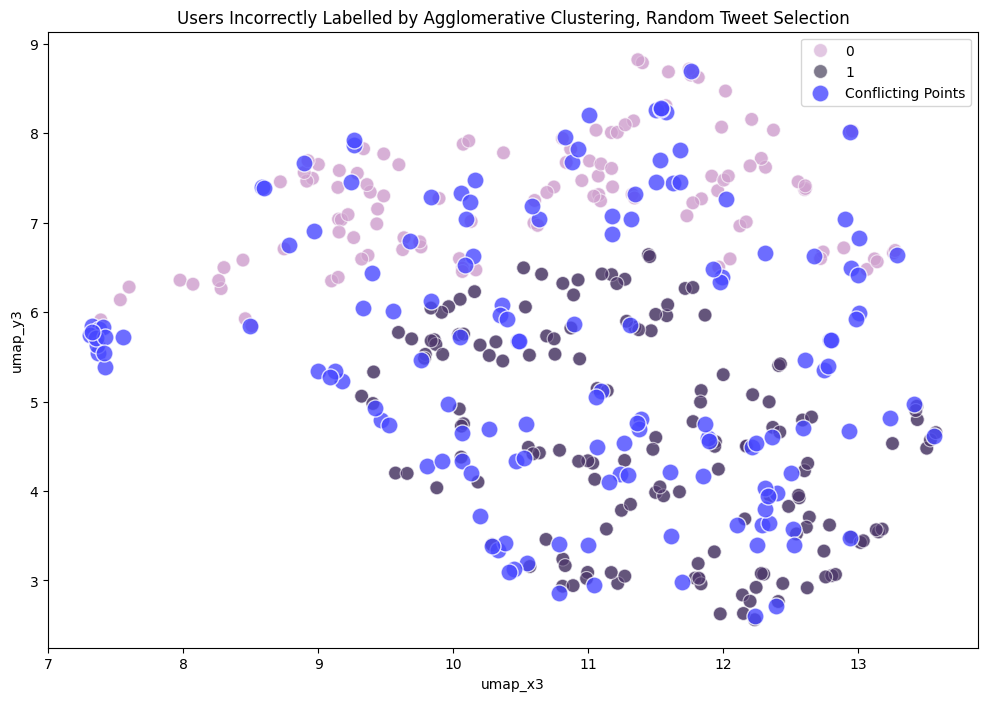

In [ ]:
# Visualising incorrect labellings
for i, model_name in enumerate(model_names):

        plt.figure(figsize=(12, 8))

        filtered_data_rand = random_data[~random_data[conflict_column]].copy()
        # User clusters without conflicting points
        sns.scatterplot(
            x = f'umap_x{i+1}',
            y = f'umap_y{i+1}',
            hue = f'umap_cluster_label{i+1}',
            data = filtered_data_rand,
            palette=[palette[1], palette[5]],
            marker='o',
            s=100,
            alpha=0.6
        )

        # Ground truth labels without the conflicting points
        sns.scatterplot(
            x=f'umap_x{i+1}',
            y=f'umap_y{i+1}',
            hue='label',
            data=filtered_data_rand,
            palette=[palette[1], palette[4]],
            marker='o',
            s=100,
            alpha=0.6,
            legend=False  # Disable the legend for ground truth to avoid conflict
        )

        # Highlight conflicting points
        sns.scatterplot(
            x=f'umap_x{i+1}',
            y=f'umap_y{i+1}',
            data=random_data[random_data[f'umap_conflict{i+1}']],
            color=extra_palette[0],
            marker='o',
            s=150,
            alpha=0.8,
            label='Conflicting Points'
        )

        plt.title(f'Users Incorrectly Labelled by {model_name} Clustering, Random Tweet Selection')
        plt.legend(loc='upper right', title='')

        plt.show()

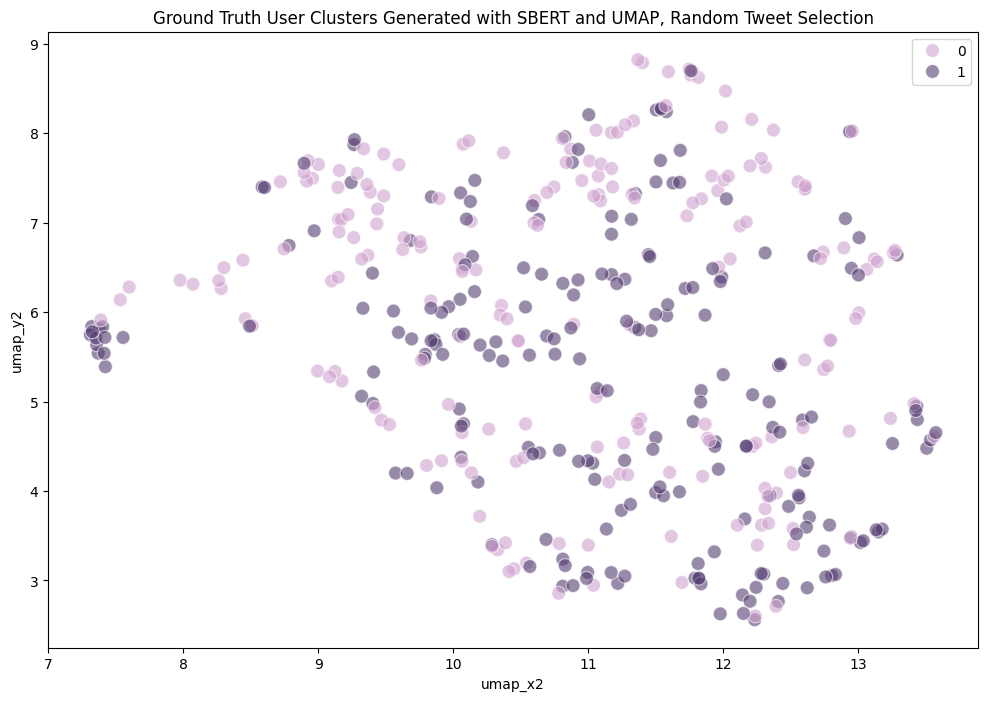

In [ ]:
plt.figure(figsize=(12, 8))

# Ground truth labels without conflicting points
sns.scatterplot(
    x=f'umap_x2',
    y=f'umap_y2',
    hue='label',
    #data=select_data[~select_data[f'umap_conflict2']],
    data=random_data,
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6,
    legend=True  # Disable the legend for ground truth to avoid conflict
    )

plt.title(f'Ground Truth User Clusters Generated with SBERT and UMAP, Random Tweet Selection')
plt.legend(loc='upper right', title='')
plt.show()

In [ ]:
# Weighted accuracy
y_true = random_data['label']

print("Balanced accuracy results, SBERT + UMAP: ")
for i, model_name in enumerate(cluster_models):

    y_pred = random_data[f'umap_cluster_label{i+1}']
    b_acc = balanced_accuracy_score(y_true.values, y_pred.values)
    print(f'{model_name}: {b_acc}')

print("\nBalanced accuracy results, SBERT: ")
for i, model_name in enumerate(cluster_models):

    y_pred = random_data[f'sbert_cluster_label{i+1}']
    b_acc = balanced_accuracy_score(y_true.values, y_pred.values)
    print(f'{model_name}: {b_acc}')

Balanced accuracy results, SBERT + UMAP: 
KMeans(n_clusters=2, random_state=12): 0.43120370370370376
SpectralClustering(affinity='nearest_neighbors', n_clusters=2, random_state=12): 0.4285185185185185
AgglomerativeClustering(): 0.6418518518518519

Balanced accuracy results, SBERT: 
KMeans(n_clusters=2, random_state=12): 0.3850925925925926
SpectralClustering(affinity='nearest_neighbors', n_clusters=2, random_state=12): 0.37398148148148147
AgglomerativeClustering(): 0.5783333333333334


In [ ]:
# DBCV Analysis of Generated Clusters
for i, model_name in enumerate(model_names):
    X = random_data[[f'umap_x{i+1}', f'umap_y{i+1}']].values
    y = random_data[f'umap_cluster_label{i+1}'].values
    score = DBCV.DBCV(X, y)
    print(f"{model_name}: {score}")

# DBCV Analysis of Ground-truth Clusters
X = random_data[[f'umap_x1', f'umap_y1']].values
y = random_data[f'label'].values
score = DBCV.DBCV(X, y)
print(f"Ground Truth Clusters: {score}")

K-means: -0.46075515062278066
Spectral: -0.6811339620922068
Agglomerative: -0.5792862410194394
Ground Truth Clusters: -0.7671981923198342


In [ ]:
# Silhouette Score Analysis of Generated Clusters
print("Silhouette Scores for clusters generated from random selection of data.")
for i, model_name in enumerate(model_names):
    labels = random_data[f'umap_cluster_label{i+1}'].values
    embds = random_data[[f'umap_x1', f'umap_y1']].values
    sil_score = silhouette_score(embds, labels)
    print(f"{model_name}: {score}")

# Silhouette Score Analysis of Ground-truth Clusters
embds = random_data[[f'umap_x1', f'umap_y1']].values
labels = random_data[f'label'].values
sil_score = silhouette_score(embds, labels)
print(f"Ground Truth Clusters: {score}")

Silhouette Scores for clusters generated from random selection of data.
K-means: -0.7671981923198342
Spectral: -0.7671981923198342
Agglomerative: -0.7671981923198342
Ground Truth Clusters: -0.7671981923198342


## BERTopic clustering pipeline  
HDBSCAN as the main clustering algorithm and NN classification of the noise points

In [ ]:
#label_map = {'Democrat': 0, 'Republican': 1}
#select_data['label'] = select_data['label'].map(label_map)

docs = select_data['text']
docs_rand = random_data['text']

In [ ]:
def performance_calculation(y_true, y_pred) -> dict:
    """
    :param y_true: the ground-truth labels as df column
    :param y_pred: the predicted labels as df column
    :returns: a dictionary with 4 accuracy metrics
              -  acc: accuracy
              -  prec: precision
              -  rec: recall
              -  b_acc: balanced accuracy
    """
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    b_acc = balanced_accuracy_score(y_true, y_pred)

    return {"acc":acc, "prec":prec, "rec": rec, 'b_acc': b_acc}

#### BERTopic Hyperparameter Tuning



In [ ]:
start_time = time.time()

# Augmenting the default patterns in the Representation Model

main_representation_model = KeyBERTInspired()
aspect_representation_model1 = PartOfSpeech("en_core_web_sm")

pos_patterns1 = [
            [{'POS': 'ADJ'}, {'POS': 'NOUN'}],
            [{'POS': 'NOUN'}], [{'POS': 'ADJ'}],
            [{'POS': 'ADV'}, {'POS': 'VERB'}],
            [{'POS': 'VERB'}] # Default and ADV+VERB, VERB
]

pos_patterns2 = [[{'POS': 'ADJ'}, {'POS': 'NOUN'}],
            [{'POS': 'NOUN'}], [{'POS': 'ADJ'}],
            [{'POS': 'ADV'}, {'POS': 'VERB'}],
             # Default and ADV + VERB
]

pos_patterns3 = [
            [{'POS': 'ADJ'}, {'POS': 'NOUN'}],
            [{'POS': 'NOUN'}], [{'POS': 'ADJ'}],
            [{'POS': 'VERB'}] # Default and VERB
]

pos_patterns4 = [[{'POS': 'ADJ'}, {'POS': 'NOUN'}],
            [{'POS': 'NOUN'}], [{'POS': 'ADJ'}]] # Default

# HYPS to tune
pos_patterns = [pos_patterns1, pos_patterns2, pos_patterns3, pos_patterns4]
n_neighbors = [1, 5, 9, 19]
# Cross-val
n_splits = 5
results = {}
param_combs = {}

# Perform grid search amid cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=13)

for z, (pos_pattern, n_neighbor) in enumerate(product(pos_patterns, n_neighbors), start=1):
    param_combs[z] = (pos_pattern, n_neighbor)

    total_bal_accuracy = 0

    for train_idx, test_idx in kf.split(docs):

        # Split data into train and test sets
        train_docs, test_docs = [docs[i] for i in train_idx], [docs[i] for i in test_idx]

        # Initialize supporting models
        representation_model = PartOfSpeech("en_core_web_sm", pos_patterns=pos_pattern)
        aspect_representation_model2 = [KeyBERTInspired(top_n_words=40),
                                        MaximalMarginalRelevance(diversity=.5)]
        representation_model = {
          "Main": main_representation_model,
          "Aspect1":  aspect_representation_model1,
          "Aspect2":  aspect_representation_model2
        }
        # Vectorizer Model
        vectorizer_model = CountVectorizer(stop_words = 'english')
        # UMAP Model
        umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine')
        # HDBSCAN Model
        hdbscan_model = HDBSCAN(min_cluster_size=20, prediction_data=True)

        # BERTopic
        topic_model = BERTopic(hdbscan_model=hdbscan_model,
                              embedding_model='all-MiniLM-L6-v2',
                              #embedding_model = embedderSBERT,
                              representation_model = representation_model,
                              vectorizer_model = vectorizer_model,
                              umap_model = umap_model,
                              nr_topics = 3)

        # Fit and transform the documents
        topics, probs = topic_model.fit_transform(docs)
        transformed_topics, embeddings = topic_model.transform(docs)
        embeddings = np.array(embeddings)
        if embeddings.ndim == 1:
            embeddings = embeddings.reshape(-1, 1)

        # Identify (non)noise datapoints
        noise_indices = np.where(np.array(topics) == -1)[0]
        non_noise_indices = np.where(np.array(topics) != -1)[0]
        noise_embeddings = embeddings[noise_indices]
        non_noise_embeddings = embeddings[non_noise_indices]

        # Initialize NearestNeighbors
        nn = NearestNeighbors(n_neighbors=n_neighbor)
        nn.fit(non_noise_embeddings)

        # Find the nearest non-noise point for each noise point
        nearest_non_noise_indices = nn.kneighbors(noise_embeddings, return_distance=False).flatten()

        # Assign the label of the nearest non-noise point to each noise point
        for idx, noise_idx in enumerate(noise_indices):
            topics[noise_idx] = topics[non_noise_indices[nearest_non_noise_indices[idx]]]

        labels = select_data['label'].to_list()
        # Calculate performance
        performance = performance_calculation(labels, topics)
        bal_accuracy = performance['b_acc']
        total_bal_accuracy += bal_accuracy
        conf_matrix = confusion_matrix(labels, topics)

    avg_bal_accuracy = total_bal_accuracy / n_splits
    results[z] = avg_bal_accuracy

# Find the best combination of hyperparameters based on average accuracy
best_z = max(results, key=results.get)
best_pos_pattern, best_n_neighbor = param_combs[best_z]
best_bal_accuracy = results[best_z]

print("Best hyperparameters:")
print(f"pos_pattern: {best_pos_pattern}")
print(f"n_neighbors: {best_n_neighbor}")
print(f"Average balanced accuracy: {best_bal_accuracy}")

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

KeyboardInterrupt: 

In [ ]:
pos_patterns4 = [[{'POS': 'ADJ'}, {'POS': 'NOUN'}],
            [{'POS': 'NOUN'}], [{'POS': 'ADJ'}]] # Default

#### Single BERTopic, filtered data

In [ ]:
docs = select_data['text']
# Tuned HYPS
pos_pattern = pos_patterns4
n_neighbors = 19

representation_model = PartOfSpeech("en_core_web_sm", pos_patterns=pos_pattern)
aspect_representation_model2 = [KeyBERTInspired(top_n_words=40),
                                        MaximalMarginalRelevance(diversity=.5)]
representation_model = {
    "Main": main_representation_model,
    "Aspect1":  aspect_representation_model1,
    "Aspect2":  aspect_representation_model2
    }
# Vectorizer Model
vectorizer_model = CountVectorizer(stop_words = 'english')
# UMAP Model
umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine', random_state = 12)
# HDBSCAN Model
hdbscan_model = HDBSCAN(min_cluster_size=20, prediction_data=True)

# BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model,
                        embedding_model='all-MiniLM-L6-v2',
                        representation_model = representation_model,
                        vectorizer_model = vectorizer_model,
                        umap_model = umap_model,
                        nr_topics = 3)

# Fit and transform the documents
topics, probs = topic_model.fit_transform(docs)
noisy_topics = topics
transformed_topics, embeddings = topic_model.transform(docs)
embeddings = np.array(embeddings)
if embeddings.ndim == 1:
    embeddings = embeddings.reshape(-1, 1)

# Identifying (non)noise datapoints
noise_indices = np.where(np.array(topics) == -1)[0]
non_noise_indices = np.where(np.array(topics) != -1)[0]
noise_embeddings = embeddings[noise_indices]
non_noise_embeddings = embeddings[non_noise_indices]

# Initialize NearestNeighbors
nn = NearestNeighbors(n_neighbors=n_neighbors)
nn.fit(non_noise_embeddings)

# Find the nearest non-noise point for each noise point
nearest_non_noise_indices = nn.kneighbors(noise_embeddings, return_distance=False).flatten()

# Assign the label of the nearest non-noise point to each noise point
for idx, noise_idx in enumerate(noise_indices):
    topics[noise_idx] = topics[non_noise_indices[nearest_non_noise_indices[idx]]]

# Document the topic labels
select_data[f'topicA'] = topics

# Extract UMAP embeds
umap_embeddings = umap_model.fit_transform(embeddings)
select_data[f'BERTopic_umap_x1'] = umap_embeddings[:, 0]
select_data[f'BERTopic_umap_y1'] = umap_embeddings[:, 1]
umap_embeddings = select_data[[f'BERTopic_umap_x1', f'BERTopic_umap_y1']].values

# Document the performance
conf_matrix = confusion_matrix(select_data['label'], select_data[f'topicA'])
performance = performance_calculation(select_data['label'], select_data[f'topicA'])

In [ ]:
print("Balanced accuracy:  ", performance['b_acc'])
print("Precision:  ", performance['prec'])
print("Recall:  ", performance['rec'])

Balanced accuracy:   0.6176851851851852
Precision:   0.6350710900473934
Recall:   0.6203703703703703


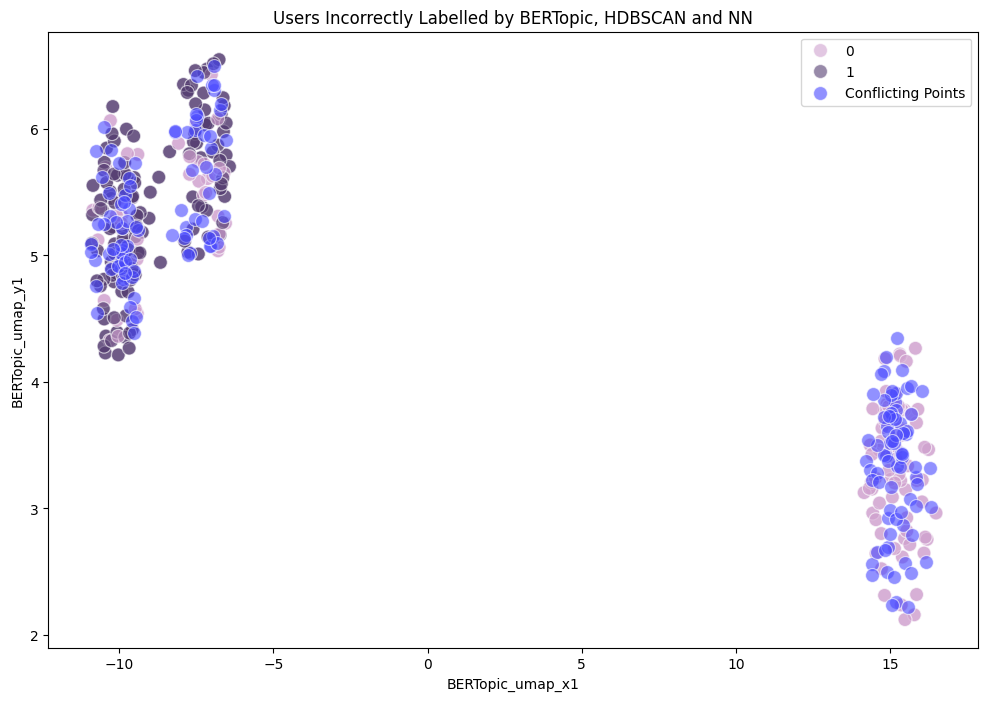

In [ ]:
select_data['conflictA'] = (select_data['topicA'] != select_data['label'])
extra_palette = sns.color_palette(palette='bwr')
plt.figure(figsize=(12, 8))

# Plot the user clusters without conflicting points
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='topicA',
    data=select_data[~select_data['conflictA']],
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6
)

# Plot the ground truth labels without conflicting points
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='label',
    data=select_data[~select_data['conflictA']],
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6,
    legend=False  # Disable the legend for ground truth to avoid conflict
)

# Highlight conflicting points with a specific color
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    data=select_data[select_data['conflictA']],
    color=extra_palette[0],  # Specific color for conflicting points
    marker='o',
    s=100,
    alpha=0.6,
    label='Conflicting Points'
)

plt.title('Users Incorrectly Labelled by BERTopic, HDBSCAN and NN')
plt.legend(loc='upper right', title='')

plt.show()

In [ ]:
# Fine-Tuned BERTopic classification without the NN
docs = select_data['text']

# BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model,
                        embedding_model='all-MiniLM-L6-v2',
                        representation_model = representation_model,
                        vectorizer_model = vectorizer_model,
                        umap_model = umap_model,
                        nr_topics = 3)

# Fit and transform the documents
topics, probs = topic_model.fit_transform(docs)
transformed_topics, embeddings = topic_model.transform(docs)
embeddings = np.array(embeddings)
if embeddings.ndim == 1:
    embeddings = embeddings.reshape(-1, 1)

# Document the topic labels
select_data[f'topicNoNN'] = topics

# Extract UMAP embeds
umap_embeddings = umap_model.fit_transform(embeddings)
select_data[f'BERTopic_umap_x1'] = umap_embeddings[:, 0]
select_data[f'BERTopic_umap_y1'] = umap_embeddings[:, 1]
umap_embeddings = select_data[[f'BERTopic_umap_x1', f'BERTopic_umap_y1']].values

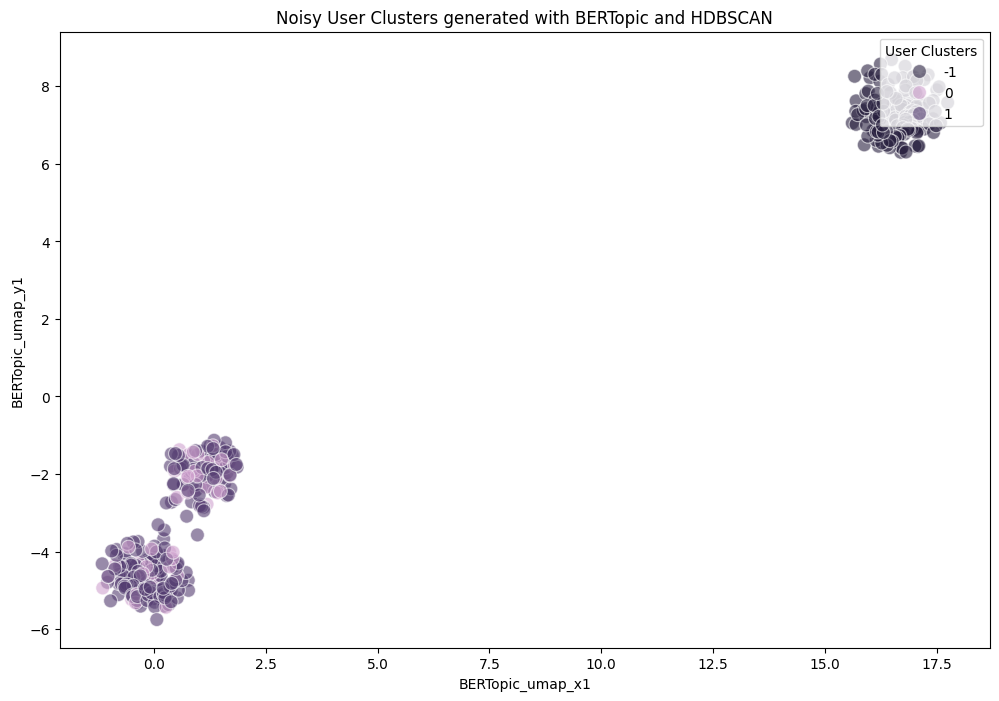

In [ ]:
# Democrats and Republicans Ground Truth Labels
plt.figure(figsize=(12, 8))

# Plot the ground truth labels without conflicting points
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='topicNoNN',
    #data=select_data[~select_data[f'umap_conflict2']],
    data=select_data,
    palette=[palette[5], palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6,
    legend=True  # Disable the legend for ground truth to avoid conflict
    )

plt.title(f'Noisy User Clusters generated with BERTopic and HDBSCAN')
plt.legend(loc='upper right', title='User Clusters')
plt.show()

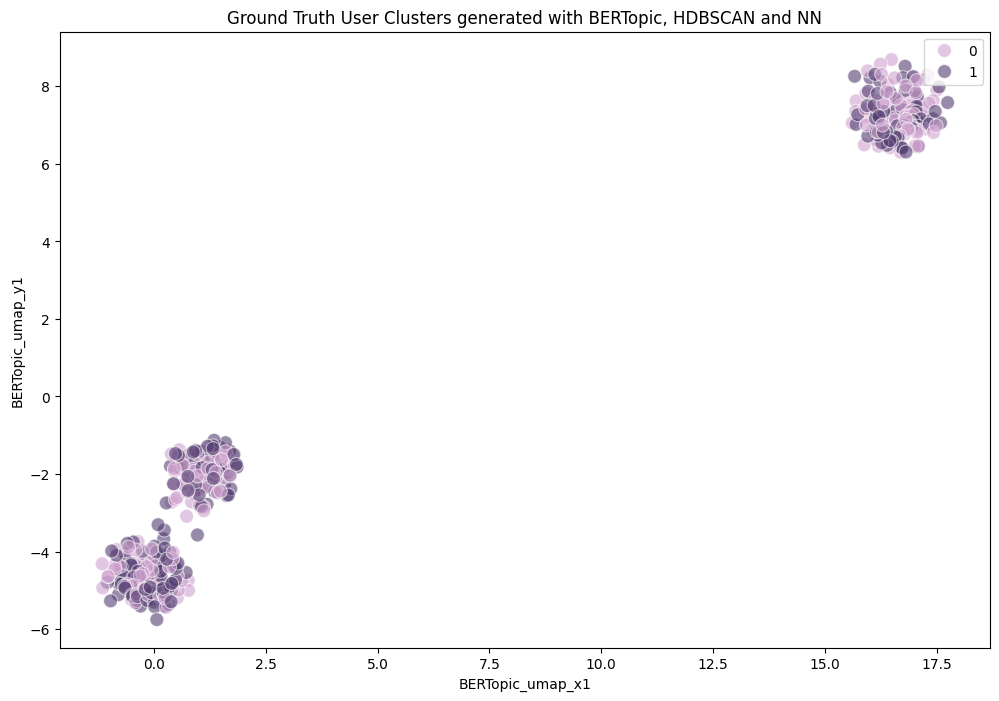

In [ ]:
# Democrats and Republicans Ground Truth Labels
plt.figure(figsize=(12, 8))

# Plot the ground truth labels without conflicting points
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='label',
    #data=select_data[~select_data[f'umap_conflict2']],
    data=select_data,
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6,
    legend=True  # Disable the legend for ground truth to avoid conflict
    )

plt.title(f'Ground Truth User Clusters generated with BERTopic, HDBSCAN and NN')
plt.legend(loc='upper right', title='')
plt.show()

DBCV evaluation

In [ ]:
# DBCV Analysis of Generated Clusters
X = select_data[['BERTopic_umap_x1', 'BERTopic_umap_y1']].values
y = select_data[f'topicA'].values
score = DBCV.DBCV(X, y)
print(f"DCSV score for generated BERTopic + NN clusters: {score}")

# DBCV Analysis of Ground-truth Clusters
X = select_data[['BERTopic_umap_x1', 'BERTopic_umap_y1']].values
y = select_data[f'label'].values
score = DBCV.DBCV(X, y)
print(f"DCSV score for ground-truth BERTopic clusters: {score}")

Silhouette score evaluation

In [ ]:
# Silhouette Score Analysis of Generated Clusters
print("Silhouette Scores BERTopic, filtered data.")
y = select_data[f'topicA'].values
X = select_data[['BERTopic_umap_x1', 'BERTopic_umap_y1']].values
sil_score = silhouette_score(X, y)
print(f"Generated: {score}")

# Silhouette Score Analysis of Ground-truth Clusters
X = select_data[['BERTopic_umap_x1', 'BERTopic_umap_y1']].values
y = select_data[f'label'].values
sil_score = silhouette_score(X, y)
print(f"Ground Truth: {score}")

#### Single BERTopic, random data

In [ ]:
random_data = df[['Party', 'Random_selection']] # as opposed to select_data
random_data.rename(columns={f"Random_selection": "text", "Party": "label"}, inplace = True)

In [ ]:
label_map = {'Democrat': 0, 'Republican': 1}
random_data['label'] = random_data['label'].map(label_map)

In [ ]:
docs = random_data['text']
# Tuned HYPS
pos_pattern = pos_patterns4
n_neighbors = 19

representation_model = PartOfSpeech("en_core_web_sm", pos_patterns=pos_pattern)
aspect_representation_model2 = [KeyBERTInspired(top_n_words=40),
                                        MaximalMarginalRelevance(diversity=.5)]
representation_model = {
    "Main": main_representation_model,
    "Aspect1":  aspect_representation_model1,
    "Aspect2":  aspect_representation_model2
    }
# Vectorizer Model
vectorizer_model = CountVectorizer(stop_words = 'english')
# UMAP Model
umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine', random_state = 12)
# HDBSCAN Model
hdbscan_model = HDBSCAN(min_cluster_size=20, prediction_data=True)

# BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model,
                        embedding_model='all-MiniLM-L6-v2',
                        representation_model = representation_model,
                        vectorizer_model = vectorizer_model,
                        umap_model = umap_model,
                        nr_topics = 3)
# Fit and transform the documents
topics, probs = topic_model.fit_transform(docs)
transformed_topics, embeddings = topic_model.transform(docs)
embeddings = np.array(embeddings)
if embeddings.ndim == 1:
    embeddings = embeddings.reshape(-1, 1)

# Identify (non)noise datapoints
noise_indices = np.where(np.array(topics) == -1)[0]
non_noise_indices = np.where(np.array(topics) != -1)[0]
noise_embeddings = embeddings[noise_indices]
non_noise_embeddings = embeddings[non_noise_indices]

# Initialize NearestNeighbors
nn = NearestNeighbors(n_neighbors=n_neighbors)
nn.fit(non_noise_embeddings)

# Find the nearest non-noise point for each noise point
nearest_non_noise_indices = nn.kneighbors(noise_embeddings, return_distance=False).flatten()

# Assign the label of the nearest non-noise point to each noise point
for idx, noise_idx in enumerate(noise_indices):
    topics[noise_idx] = topics[non_noise_indices[nearest_non_noise_indices[idx]]]

# Document the topic labels
random_data[f'topicA'] = topics

# Extract UMAP embeds
umap_embeddings = umap_model.fit_transform(embeddings)
random_data[f'BERTopic_umap_x1'] = umap_embeddings[:, 0]
random_data[f'BERTopic_umap_y1'] = umap_embeddings[:, 1]
umap_embeddings = select_data[[f'BERTopic_umap_x1', f'BERTopic_umap_y1']].values

# Document the performance
conf_matrix = confusion_matrix(random_data['label'], random_data[f'topicA'])
performance = performance_calculation(random_data['label'], random_data[f'topicA'])

In [ ]:
print("Balanced accuracy:  ", performance['b_acc'])
print("Precision:  ", performance['prec'])
print("Recall:  ", performance['rec'])

Balanced accuracy:   0.43287037037037035
Precision:   0.4094488188976378
Recall:   0.24074074074074073


Generated clusters

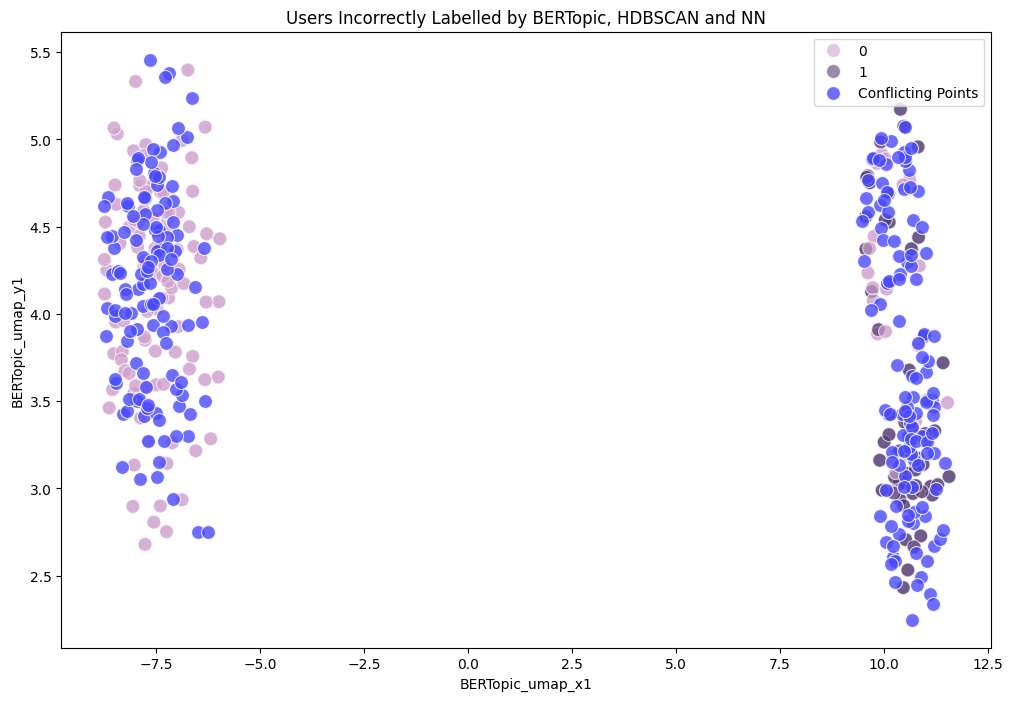

In [ ]:
random_data['conflictA'] = (random_data['topicA'] != random_data['label'])
extra_palette = sns.color_palette(palette='bwr')
plt.figure(figsize=(12, 8))

# Plot the user clusters without conflicting points
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='topicA',
    data=random_data[~random_data['conflictA']],
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6
)

# Plot the ground truth labels without conflicting points
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='label',
    data=random_data[~random_data['conflictA']],
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6,
    legend=False  # Disable the legend for ground truth to avoid conflict
)

# Highlight conflicting points with a specific color
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    data=random_data[random_data['conflictA']],
    color=extra_palette[0],  # Specific color for conflicting points
    marker='o',
    s=100,
    alpha=0.8,
    label='Conflicting Points'
)

plt.title('Users Incorrectly Labelled by BERTopic, HDBSCAN and NN')
plt.legend(loc='upper right', title='')

plt.show()

In [ ]:
# Fine-Tuned BERTopic classification without the NN
docs = random_data['text']

# BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model,
                        embedding_model='all-MiniLM-L6-v2',
                        representation_model = representation_model,
                        vectorizer_model = vectorizer_model,
                        umap_model = umap_model,
                        nr_topics = 3)

# Fit and transform the documents
topics, probs = topic_model.fit_transform(docs)
transformed_topics, embeddings = topic_model.transform(docs)
embeddings = np.array(embeddings)
if embeddings.ndim == 1:
    embeddings = embeddings.reshape(-1, 1)

# Document the topic labels
random_data[f'topicNoNN'] = topics

# Extract UMAP embeds
umap_embeddings = umap_model.fit_transform(embeddings)
random_data[f'BERTopic_umap_x1'] = umap_embeddings[:, 0]
random_data[f'BERTopic_umap_y1'] = umap_embeddings[:, 1]
umap_embeddings = random_data[[f'BERTopic_umap_x1', f'BERTopic_umap_y1']].values

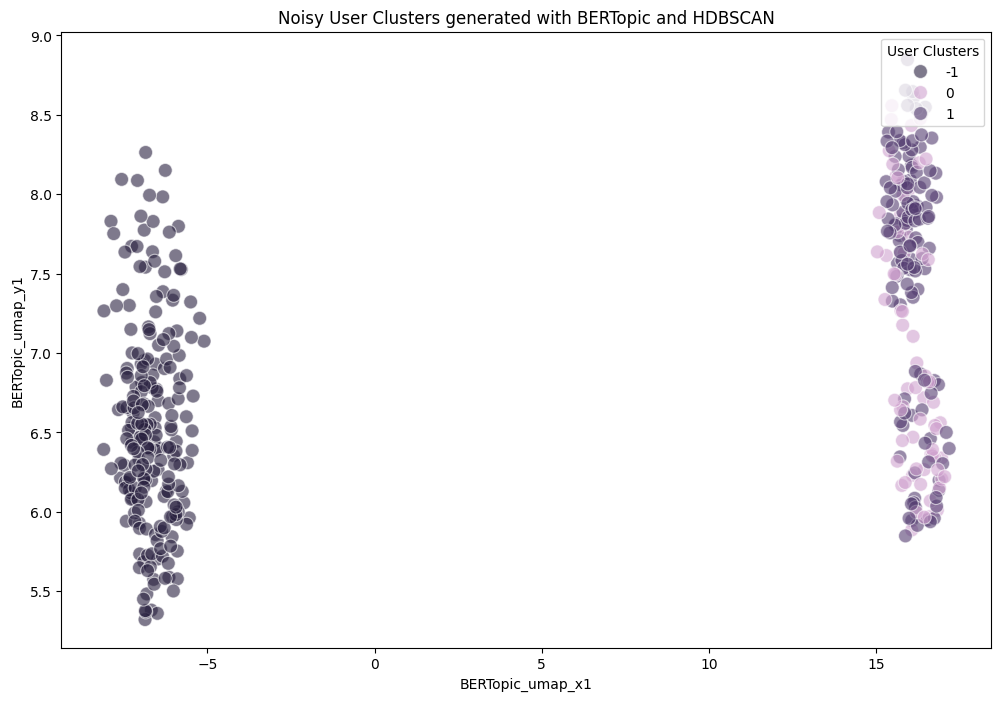

In [ ]:
# Democrats and Republicans Noisy Labels
plt.figure(figsize=(12, 8))

# Plot the ground truth labels without conflicting points
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='topicNoNN',
    #data=select_data[~select_data[f'umap_conflict2']],
    data=random_data,
    palette=[palette[5], palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6,
    legend=True  # Disable the legend for ground truth to avoid conflict
    )

plt.title(f'Noisy User Clusters generated with BERTopic and HDBSCAN')
plt.legend(loc='upper right', title='User Clusters')
plt.show()

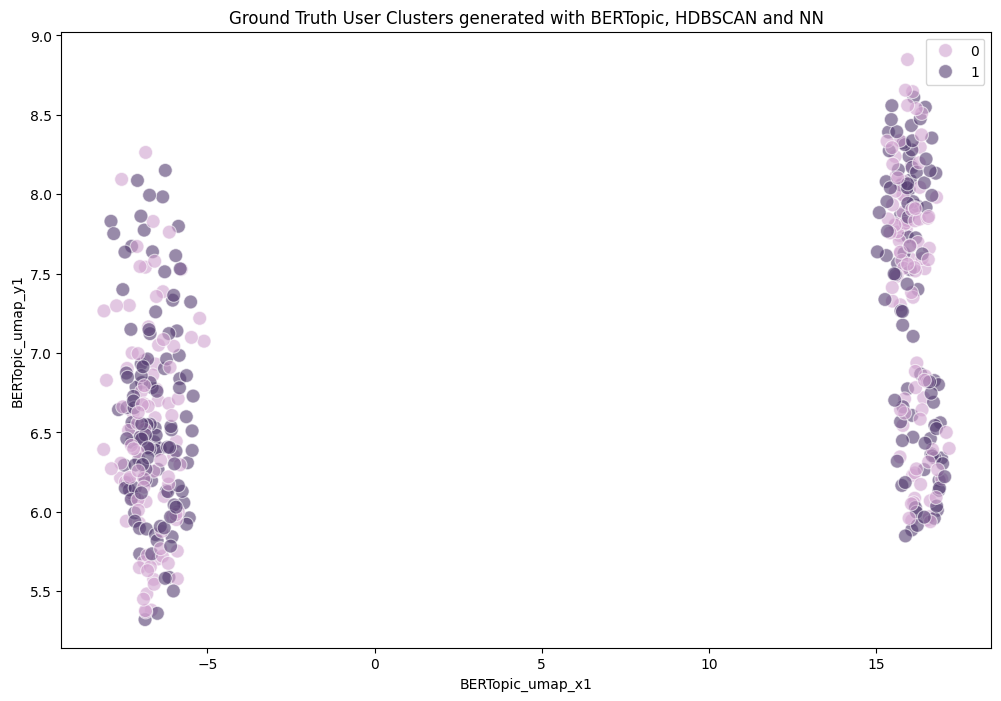

In [ ]:
# Democrats and Republicans Ground Truth Labels
plt.figure(figsize=(12, 8))

# Plot the ground truth labels without conflicting points
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='label',
    #data=select_data[~select_data[f'umap_conflict2']],
    data=random_data,
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6,
    legend=True  # Disable the legend for ground truth to avoid conflict
    )

plt.title(f'Ground Truth User Clusters generated with BERTopic, HDBSCAN and NN')
plt.legend(loc='upper right', title='')
plt.show()

DBCV evaluation

In [ ]:
# DBCV Analysis of Generated Clusters
print("DBCV Indices BERTopic, random data.")
X = umap_embeddings
y = random_data[f'topicA'].values
score = DBCV.DBCV(X, y)
print(f"Generated clusters: {score}")

# DBCV Analysis of Ground-truth Clusters
X = umap_embeddings
y = random_data[f'label'].values
score = DBCV.DBCV(X, y)
print(f"Ground-truth clusters: {score}")

DBCV Indices BERTopic, random data.
Generated clusters: -0.8352452539999374
Ground-truth clusters: -0.8134145456861317


Silhouette score evaluation

In [ ]:
# Silhouette Score Analysis of Generated Clusters
print("Silhouette Scores BERTopic, random data.")
y = random_data[f'topicA'].values
X = umap_embeddings
sil_score = silhouette_score(X, y)
print(f"Generated clusters: {score}")

# Silhouette Score Analysis of Ground-truth Clusters
X = umap_embeddings
y = random_data[f'label'].values
sil_score = silhouette_score(X, y)
print(f"Ground Truth clusters: {score}")

Silhouette Scores BERTopic, random data.
Generated clusters: -0.8134145456861317
Ground Truth clusters: -0.8134145456861317


### DoubleBERTopic (BERTopic that treats noise cluster as separate data)

#### Filtered data

In [ ]:
docs = select_data['text']
# Tuned HYPS
pos_pattern = pos_patterns4
n_neighbors = 19
df1 = {"Non_noise_embeddings": [],
       "topicsNonNoise": [],
       "ground_truth_labels": []
       }
df2 = {"Noise_embeddings": [],
       "topicsNoise": [],
       "ground_truth_labels": []
       }
df1=pd.DataFrame()
df2=pd.DataFrame()

main_representation_model = KeyBERTInspired()
aspect_representation_model1 = PartOfSpeech("en_core_web_sm")
representation_model = PartOfSpeech("en_core_web_sm", pos_patterns=pos_pattern)
aspect_representation_model2 = [KeyBERTInspired(top_n_words=40),
                                        MaximalMarginalRelevance(diversity=.5)]

representation_model = {
    "Main": main_representation_model,
    "Aspect1":  aspect_representation_model1,
    "Aspect2":  aspect_representation_model2
    }

# Vectorizer Model
vectorizer_model = CountVectorizer(stop_words = 'english')
# UMAP Model
umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine', random_state = 12)
# HDBSCAN Model
hdbscan_model = HDBSCAN(min_cluster_size=20, prediction_data=True)
hdbscan_model2 = HDBSCAN(min_cluster_size=10, prediction_data=True)

# BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model,
                        embedding_model='all-MiniLM-L6-v2',
                        representation_model = representation_model,
                        vectorizer_model = vectorizer_model,
                        umap_model = umap_model,
                        nr_topics = 3)
# Fit and transform the documents
topics, probs = topic_model.fit_transform(docs)
transformed_topics, embeddings = topic_model.transform(docs)
embeddings = np.array(embeddings)
if embeddings.ndim == 1:
    embeddings = embeddings.reshape(-1, 1)

# Identifying (non)noise datapoints
noise_indices = np.where(np.array(topics) == -1)[0]
non_noise_indices = np.where(np.array(topics) != -1)[0]
noise_embeddings = list(embeddings[noise_indices])
non_noise_embeddings = list(embeddings[non_noise_indices])

# Separate the data into two dataframes, each cluster in one
df1['Non_noise_embeddings'] = non_noise_embeddings
df1['topicsNonNoise'] = np.array(topics)[non_noise_indices]
df1['ground_truth_labels'] = select_data['label'].iloc[non_noise_indices].values
print("Number of instances in the non-noise cluster", len(df1))

df2['Noise_embeddings'] = noise_embeddings
df2['ground_truth_labels'] = select_data['label'].iloc[noise_indices].values
docs2 = select_data['text'].iloc[noise_indices].tolist()

# UMAP embeddings extraction
umap_embeddings = umap_model.fit_transform(embeddings)
select_data[f'BERTopic_umap_x1'] = umap_embeddings[:, 0]
select_data[f'BERTopic_umap_y1'] = umap_embeddings[:, 1]
umap_embeddings = select_data[[f'BERTopic_umap_x1', f'BERTopic_umap_y1']].values

# Documenting the performance
conf_matrix = confusion_matrix(df1['ground_truth_labels'], df1[f'topicsNonNoise'])
performance1 = performance_calculation(df1['ground_truth_labels'], df1[f'topicsNonNoise'])

# Second BERTopic
topic_model2 = BERTopic(hdbscan_model=hdbscan_model2,
                        embedding_model='all-MiniLM-L6-v2',
                        representation_model = representation_model,
                        vectorizer_model = vectorizer_model,
                        umap_model = umap_model,
                        nr_topics = 3)

# Running the same model on the Noise cluster
topics2, probs2 = topic_model2.fit_transform(docs2)
transformed_topics2, embeddings2 = topic_model2.transform(docs2)
embeddings2 = np.array(embeddings2)
if embeddings2.ndim == 1:
    embeddings2 = embeddings2.reshape(-1, 1)

df2['topicsNoise'] = topics2
print("Number of instances in the noise cluster: ",len(topics2))
#assert set(topics2) == 2, "Beware, there are noise classifications."

# Identifying (non)noise datapoints
noise_indices2 = np.where(np.array(topics2) == -1)[0] # 1
non_noise_indices2 = np.where(np.array(topics2) != -1)[0]# 2

noise_embeddings2 = embeddings2[noise_indices2]
non_noise_embeddings2 = embeddings2[non_noise_indices2]

proportion_noise_df2 = len(noise_indices2) / len(df2)
print(f"Proportion of noisy points in the Noise cluster: {proportion_noise_df2}")

# Initialize NearestNeighbors
nn = NearestNeighbors(n_neighbors=19)
nn.fit(non_noise_embeddings2)

# Find the nearest non-noise point for each noise point
nearest_non_noise_indices = nn.kneighbors(noise_embeddings2, return_distance=False).flatten()

# Assign the label of the nearest non-noise point to each noise point
for idx, noise_idx in enumerate(noise_indices2):
    topics2[noise_idx] = topics2[non_noise_indices2[nearest_non_noise_indices[idx]]]

df2['topicsNoise'] = topics2
performance2 = performance_calculation(df2['ground_truth_labels'],df2['topicsNoise'])

# Update select_data with the new topic labels
select_data['double_model_labels'] = [-1] * len(select_data)
select_data.loc[non_noise_indices, 'double_model_labels'] = np.array(topics)[non_noise_indices]
select_data.loc[noise_indices, 'double_model_labels'] = topics2

Number of instances in the non-noise cluster 259
Number of instances in the noise cluster:  157
Proportion of noisy points in the Noise cluster: 0.08280254777070063


In [ ]:
print("DOUBLE BERTOPIC\n")
print("Performance on the non-noise cluster:")
print("----------------------------------------------")
print(f"Balanced accuracy: {performance1['b_acc']}")
print(f"Precision: {performance1['prec']}")
print(f"Recall: {performance1['rec']}.")
print("\n\n")
print("Performance on the noise cluster:")
print("----------------------------------------------")
print(f"Balanced accuracy: {performance2['b_acc']}")
print(f"Precision: {performance2['prec']}")
print(f"Recall: {performance2['rec']}.")

DOUBLE BERTOPIC

Performance on the non-noise cluster:
----------------------------------------------
Balanced accuracy: 0.6427711568556639
Precision: 0.6350710900473934
Recall: 0.9436619718309859.



Performance on the noise cluster:
----------------------------------------------
Balanced accuracy: 0.4291761641159232
Precision: 0.125
Recall: 0.02702702702702703.


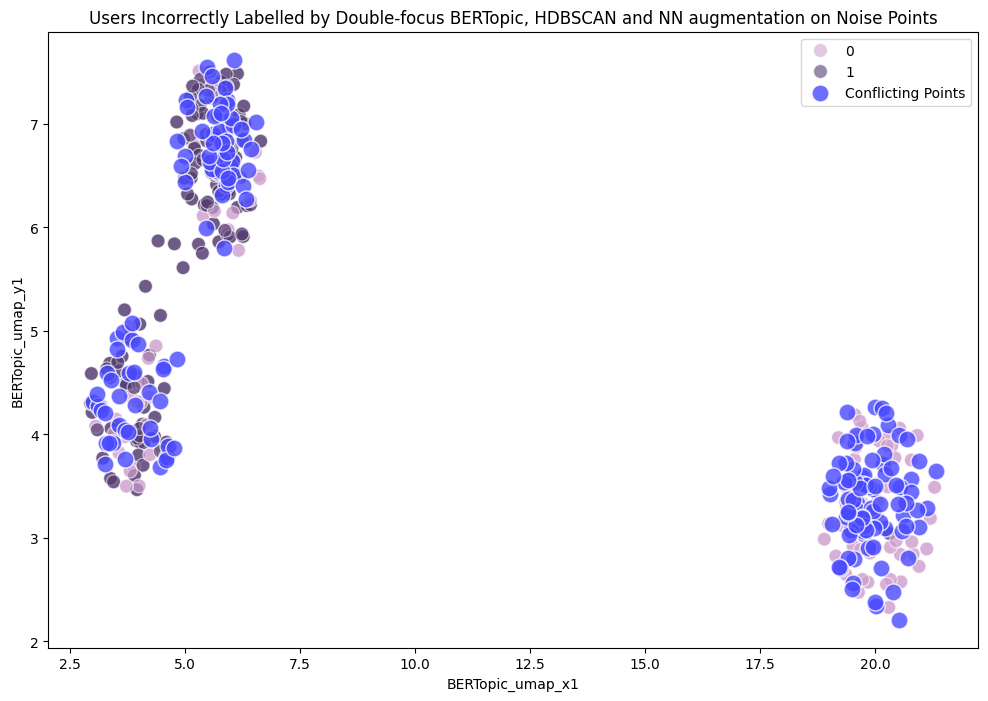

In [ ]:
extra_palette = sns.color_palette(palette='bwr')
select_data['conflict_double'] = (select_data['double_model_labels'] != select_data['label'])

plt.figure(figsize=(12, 8))

# Plot the user clusters without conflicting points
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='double_model_labels',
    data=select_data[~select_data['conflict_double']],
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6
)

# Plot the ground truth labels without conflicting points
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='label',
    data=select_data[~select_data['conflict_double']],
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6,
    legend=False  # Disable the legend for ground truth to avoid conflict
)

# Highlight conflicting points with a specific color
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    data=select_data[select_data['conflict_double']],
    color=extra_palette[0],  # Specific color for conflicting points
    marker='o',
    s=150,
    alpha=0.8,
    label='Conflicting Points'
)

plt.title('Users Incorrectly Labelled by Double-focus BERTopic, HDBSCAN and NN augmentation on Noise Points')
plt.legend(loc='upper right', title='')

plt.show()

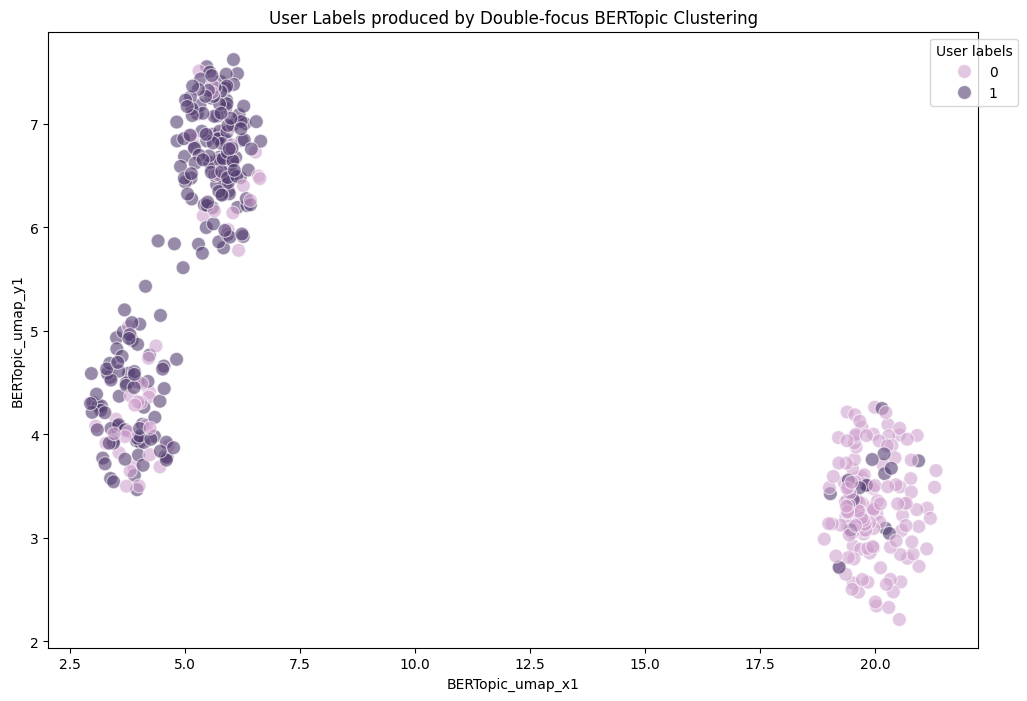

In [ ]:
# Visualise the clusters

# Update select_data with the new topic labels
select_data['double_model_labels'] = [-1] * len(select_data)
select_data.loc[non_noise_indices, 'double_model_labels'] = np.array(topics)[non_noise_indices]
select_data.loc[noise_indices, 'double_model_labels'] = topics2

#umap_embeddings = select_data[[f'BERTopic_umap_x1', f'BERTopic_umap_y1']].values

# Visualize UMAP embeddings with assigned labels
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='double_model_labels',
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6,
    data=select_data,
    legend = True)

plt.title('User Labels produced by Double-focus BERTopic Clustering')
plt.legend(title='User labels', bbox_to_anchor=(1.05, 1), loc='upper right')
plt.show()

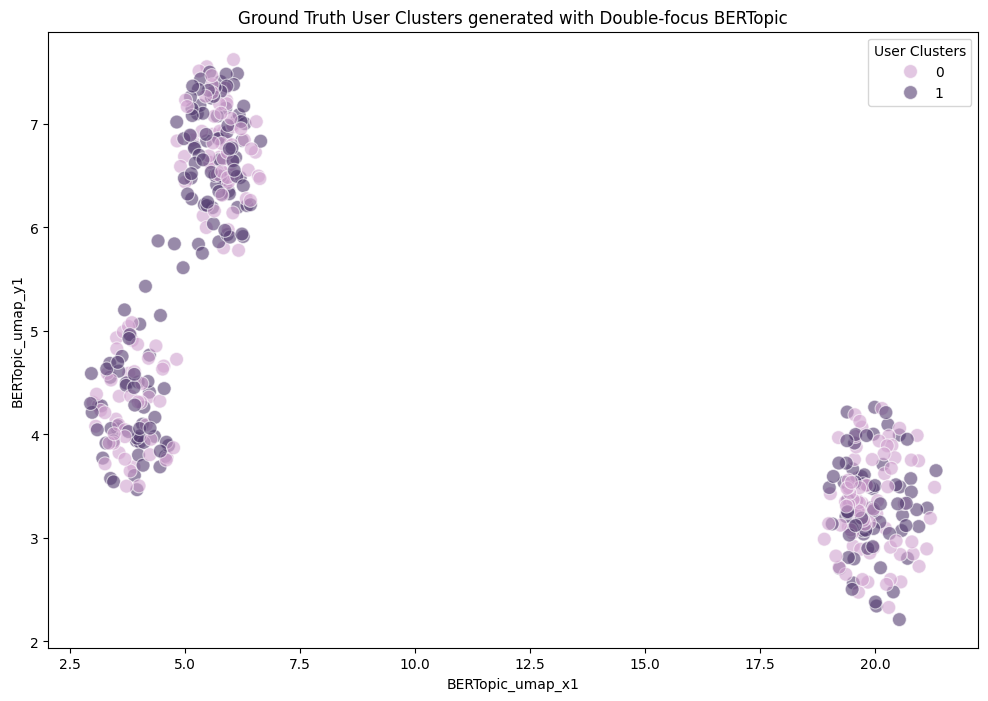

In [ ]:
# Democrats and Republicans Ground Truth Labels
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='label',
    data=select_data,
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6,
    legend=True  # Disable the legend for ground truth to avoid conflict
)

plt.title(f'Ground Truth User Clusters generated with Double-focus BERTopic')
plt.legend(loc='upper right', title='User Clusters')
plt.show()

In [ ]:
overall_double_performance = performance_calculation(select_data['label'], select_data['double_model_labels'])

In [ ]:
print("Double BERTopic performance:")
print("----------------------------------------------")
print(f"Balanced accuracy: {overall_double_performance['b_acc']}")
print(f"Precision: {overall_double_performance['prec']}")
print(f"Recall: {overall_double_performance['rec']}.")

Double BERTopic performance:
----------------------------------------------
Balanced accuracy: 0.5873148148148148
Precision: 0.5991189427312775
Recall: 0.6296296296296297.


DBCV evaluation

In [ ]:
# DBCV Analysis of Generated Clusters
print("DBCV Indices BERTopic, random data.")
X = umap_embeddings
y = select_data['double_model_labels'].values
score = DBCV.DBCV(X, y)
print(f"Generated clusters: {score}")

# DBCV Analysis of Ground-truth Clusters
X = umap_embeddings
y = select_data[f'label'].values
score = DBCV.DBCV(X, y)
print(f"Ground-truth clusters: {score}")

DBCV Indices BERTopic, random data.
Generated clusters: -0.8430187969654341
Ground-truth clusters: -0.8803094728888036


Silhouette score evaluation

In [ ]:
# Silhouette Score Analysis of Generated Clusters
print("Silhouette Scores BERTopic, random data.")
y = select_data['double_model_labels'].values
X = umap_embeddings
sil_score = silhouette_score(X, y)
print(f"Generated clusters: {score}")

# Silhouette Score Analysis of Ground-truth Clusters
X = umap_embeddings
y = select_data[f'label'].values
sil_score = silhouette_score(X, y)
print(f"Ground Truth clusters: {score}")

Silhouette Scores BERTopic, random data.
Generated clusters: -0.8803094728888036
Ground Truth clusters: -0.8803094728888036


#### Random data

In [ ]:
docs = random_data['text']
# Tuned HYPS
pos_pattern = pos_patterns4
n_neighbors = 19
df1 = {"Non_noise_embeddings": [],
       "topicsNonNoise": [],
       "ground_truth_labels": []
       }
df2 = {"Noise_embeddings": [],
       "topicsNoise": [],
       "ground_truth_labels": []
       }
df1=pd.DataFrame()
df2=pd.DataFrame()

main_representation_model = KeyBERTInspired()
aspect_representation_model1 = PartOfSpeech("en_core_web_sm")
representation_model = PartOfSpeech("en_core_web_sm", pos_patterns=pos_pattern)
aspect_representation_model2 = [KeyBERTInspired(top_n_words=40),
                                        MaximalMarginalRelevance(diversity=.5)]

representation_model = {
    "Main": main_representation_model,
    "Aspect1":  aspect_representation_model1,
    "Aspect2":  aspect_representation_model2
    }

# Vectorizer Model
vectorizer_model = CountVectorizer(stop_words = 'english')
# UMAP Model
umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine', random_state = 12)
# HDBSCAN Model
hdbscan_model = HDBSCAN(min_cluster_size=20, prediction_data=True)
hdbscan_model2 = HDBSCAN(min_cluster_size=10, prediction_data=True)

# BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model,
                        embedding_model='all-MiniLM-L6-v2',
                        representation_model = representation_model,
                        vectorizer_model = vectorizer_model,
                        umap_model = umap_model,
                        nr_topics = 3)
# Fit and transform the documents
topics, probs = topic_model.fit_transform(docs)
transformed_topics, embeddings = topic_model.transform(docs)
embeddings = np.array(embeddings)
if embeddings.ndim == 1:
    embeddings = embeddings.reshape(-1, 1)

# Identifying (non)noise datapoints
noise_indices = np.where(np.array(topics) == -1)[0]
non_noise_indices = np.where(np.array(topics) != -1)[0]
noise_embeddings = list(embeddings[noise_indices])
non_noise_embeddings = list(embeddings[non_noise_indices])

# Separate the data into two dataframes, each cluster in one
df1['Non_noise_embeddings'] = non_noise_embeddings
df1['topicsNonNoise'] = np.array(topics)[non_noise_indices]
df1['ground_truth_labels'] = select_data['label'].iloc[non_noise_indices].values
print("Number of instances in the non-noise cluster", len(df1))
# Calculate the DBCV of the non-noisy cluster --- optimization criterion for HDBSCAN

df2['Noise_embeddings'] = noise_embeddings
df2['ground_truth_labels'] = select_data['label'].iloc[noise_indices].values
docs2 = select_data['text'].iloc[noise_indices].tolist()

# UMAP embeddings extraction
umap_embeddings = umap_model.fit_transform(embeddings)
random_data[f'BERTopic_umap_x1'] = umap_embeddings[:, 0]
random_data[f'BERTopic_umap_y1'] = umap_embeddings[:, 1]
umap_embeddings = random_data[[f'BERTopic_umap_x1', f'BERTopic_umap_y1']].values

# Document the performance
conf_matrix = confusion_matrix(df1['ground_truth_labels'], df1[f'topicsNonNoise'])
performance1 = performance_calculation(df1['ground_truth_labels'], df1[f'topicsNonNoise'])

# Second BERTopic
topic_model2 = BERTopic(hdbscan_model=hdbscan_model2,
                        embedding_model='all-MiniLM-L6-v2',
                        representation_model = representation_model,
                        vectorizer_model = vectorizer_model,
                        umap_model = umap_model,
                        nr_topics = 3)

# Running the same model on the Noise cluster
topics2, probs2 = topic_model2.fit_transform(docs2)
transformed_topics2, embeddings2 = topic_model2.transform(docs2)
embeddings2 = np.array(embeddings2)
if embeddings2.ndim == 1:
    embeddings2 = embeddings2.reshape(-1, 1)

df2['topicsNoise'] = topics2
print("Number of instances in the noise cluster: ",len(topics2))
#assert set(topics2) == 2, "Beware, there are noise classifications."

# Identifying (non)noise datapoints
noise_indices2 = np.where(np.array(topics2) == -1)[0] # 1
non_noise_indices2 = np.where(np.array(topics2) != -1)[0]# 2

noise_embeddings2 = embeddings2[noise_indices2]
non_noise_embeddings2 = embeddings2[non_noise_indices2]

proportion_noise_df2 = len(noise_indices2) / len(df2)
print(f"Proportion of noisy points in the Noise cluster: {proportion_noise_df2}")

# Initialize NearestNeighbors
nn = NearestNeighbors(n_neighbors=19)
nn.fit(non_noise_embeddings2)

# Find the nearest non-noise point for each noise point
nearest_non_noise_indices = nn.kneighbors(noise_embeddings2, return_distance=False).flatten()

# Assign the label of the nearest non-noise point to each noise point
for idx, noise_idx in enumerate(noise_indices2):
    topics2[noise_idx] = topics2[non_noise_indices2[nearest_non_noise_indices[idx]]]

df2['topicsNoise'] = topics2
performance2 = performance_calculation(df2['ground_truth_labels'],df2['topicsNoise'])

# Update select_data with the new topic labels
random_data['double_model_labels'] = [-1] * len(random_data)
random_data.loc[non_noise_indices, 'double_model_labels'] = np.array(topics)[non_noise_indices]
random_data.loc[noise_indices, 'double_model_labels'] = topics2

Number of instances in the non-noise cluster 196
Number of instances in the noise cluster:  220
Proportion of noisy points in the Noise cluster: 0.5454545454545454


In [ ]:
print("DOUBLE BERTOPIC\n")
print("Performance on the non-noise cluster:")
print("----------------------------------------------")
print(f"Balanced accuracy: {performance1['b_acc']}")
print(f"Precision: {performance1['prec']}")
print(f"Recall: {performance1['rec']}.")
print("\n\n")
print("Performance on the noise cluster:")
print("----------------------------------------------")
print(f"Balanced accuracy: {performance2['b_acc']}")
print(f"Precision: {performance2['prec']}")
print(f"Recall: {performance2['rec']}.")

print("----------------------------------------------")
print("----------------------------------------------")
print("----------------------------------------------")
overall_double_performance = performance_calculation(random_data['label'], random_data['double_model_labels'])
print("Overall Double BERTopic performance:")
print("----------------------------------------------")
print(f"Balanced accuracy: {overall_double_performance['b_acc']}")
print(f"Precision: {overall_double_performance['prec']}")
print(f"Recall: {overall_double_performance['rec']}.")

DOUBLE BERTOPIC

Performance on the non-noise cluster:
----------------------------------------------
Balanced accuracy: 0.38925335832552327
Precision: 0.4094488188976378
Recall: 0.5360824742268041.



Performance on the noise cluster:
----------------------------------------------
Balanced accuracy: 0.43972044263249854
Precision: 0.4117647058823529
Recall: 0.17647058823529413.
----------------------------------------------
----------------------------------------------
----------------------------------------------
Overall Double BERTopic performance:
----------------------------------------------
Balanced accuracy: 0.40648148148148144
Precision: 0.4101123595505618
Recall: 0.33796296296296297.


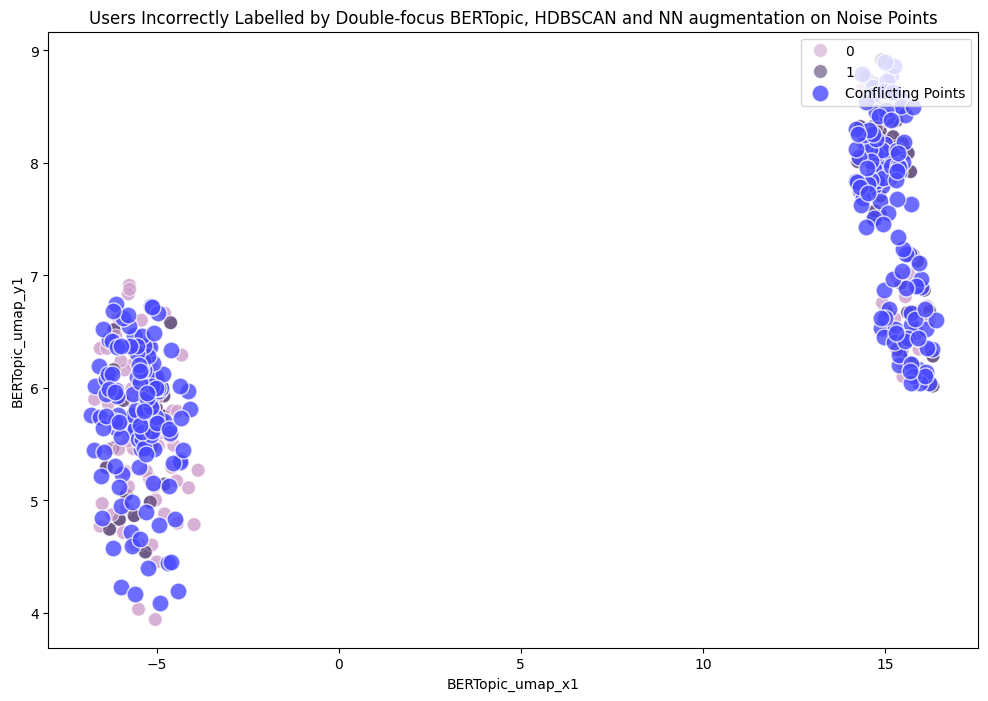

In [ ]:
extra_palette = sns.color_palette(palette='bwr')
random_data['conflict_double'] = (random_data['double_model_labels'] != random_data['label'])

plt.figure(figsize=(12, 8))

# Plot the user clusters without conflicting points
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='double_model_labels',
    data=random_data[~random_data['conflict_double']],
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6
)

# Plot the ground truth labels without conflicting points
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='label',
    data=random_data[~random_data['conflict_double']],
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6,
    legend=False  # Disable the legend for ground truth to avoid conflict
)

# Highlight conflicting points with a specific color
sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    data=random_data[random_data['conflict_double']],
    color=extra_palette[0],  # Specific color for conflicting points
    marker='o',
    s=150,
    alpha=0.8,
    label='Conflicting Points'
)

plt.title('Users Incorrectly Labelled by Double-focus BERTopic, HDBSCAN and NN augmentation on Noise Points')
plt.legend(loc='upper right', title='')

plt.show()

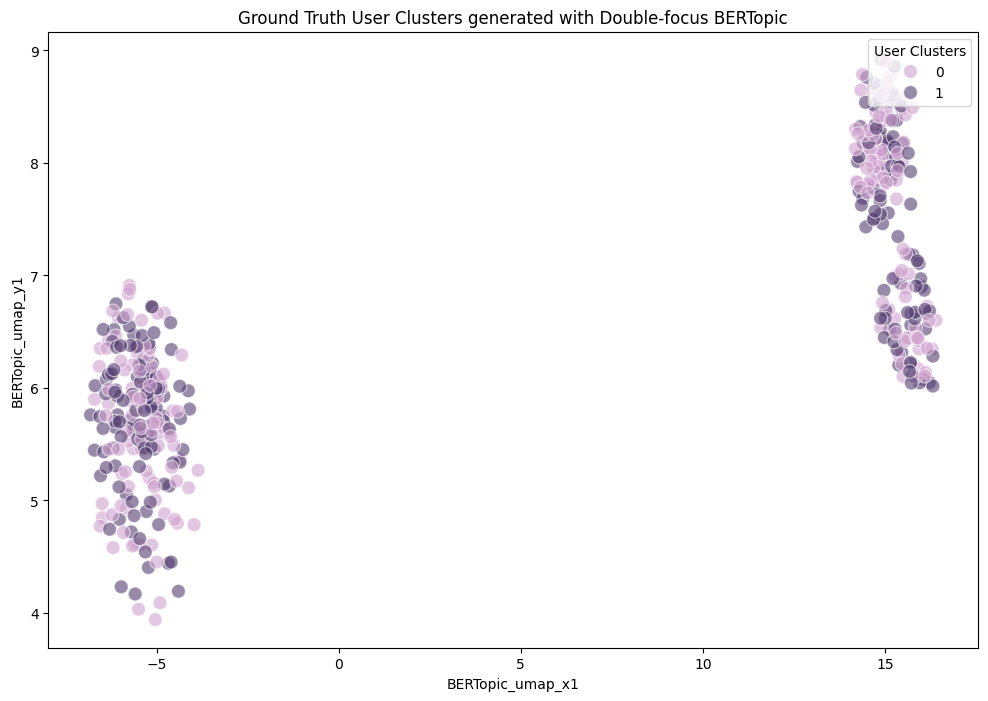

In [ ]:
# Ground-truth clusters
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x='BERTopic_umap_x1',
    y='BERTopic_umap_y1',
    hue='label',
    data=random_data,
    palette=[palette[1], palette[4]],
    marker='o',
    s=100,
    alpha=0.6,
    legend=True  # Disable the legend for ground truth to avoid conflict
)

plt.title(f'Ground Truth User Clusters generated with Double-focus BERTopic')
plt.legend(loc='upper right', title='User Clusters')
plt.show()

In [ ]:
# DBCV Analysis of Generated Clusters
print("DBCV Indices BERTopic, random data.")
X = umap_embeddings
y = random_data['double_model_labels'].values
score = DBCV.DBCV(X, y)
print(f"Generated clusters: {score}")

# DBCV Analysis of Ground-truth Clusters
X = umap_embeddings
y = random_data[f'label'].values
score = DBCV.DBCV(X, y)
print(f"Ground-truth clusters: {score}")

DBCV Indices BERTopic, random data.
Generated clusters: -0.7380589083351161
Ground-truth clusters: -0.914010067491796


In [ ]:
# Silhouette Score Analysis of Generated Clusters
print("Silhouette Scores BERTopic, random data.")
y = random_data['double_model_labels'].values
X = umap_embeddings
sil_score = silhouette_score(X, y)
print(f"Generated clusters: {score}")

# Silhouette Score Analysis of Ground-truth Clusters
X = umap_embeddings
y = random_data[f'label'].values
sil_score = silhouette_score(X, y)
print(f"Ground Truth clusters: {score}")

Silhouette Scores BERTopic, random data.
Generated clusters: -0.914010067491796
Ground Truth clusters: -0.914010067491796
